# Figures 

## ECCO

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms.zarr'))
wmt_budget_terms.load()

/tmp/ipykernel_2220/560759331.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms.zarr'))


<xarray.Dataset>
Dimensions:               (time: 288, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 6.155e+04 6.155e+04 ... 0.0
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

In [4]:
#indices
indices = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/indices.zarr')).load()

In [8]:
indices#.plot()

<xarray.Dataset>
Dimensions:          (time: 288)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    ecco             (time) float32 -1.17 -0.4881 0.557 ... 0.9576 0.7435 -2.925
    enso             (time) float32 1.884 1.786 1.615 ... 2.599 2.746 2.795
    fw_flx           (time) float32 -1.3 -0.8691 -2.231 ... 0.3026 0.3995 1.555
    heat_flx         (time) float32 0.001594 -0.8675 -1.919 ... -0.1446 5.151
    sam              (time) float64 -0.1225 -0.8858 -0.616 ... 0.8338 0.3187
    windstress_curl  (time) float64 -0.2194 1.103 -0.4354 ... -0.5297 0.2877

## Time mean budgets

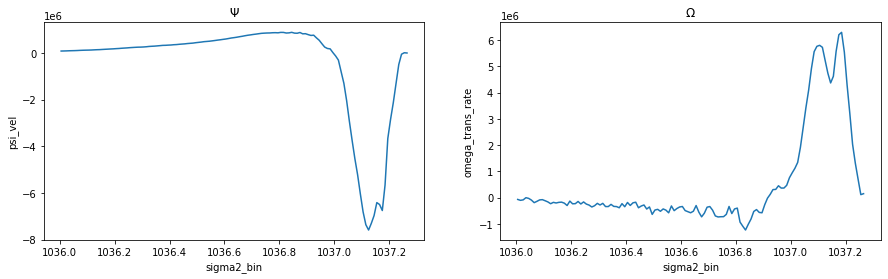

In [5]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

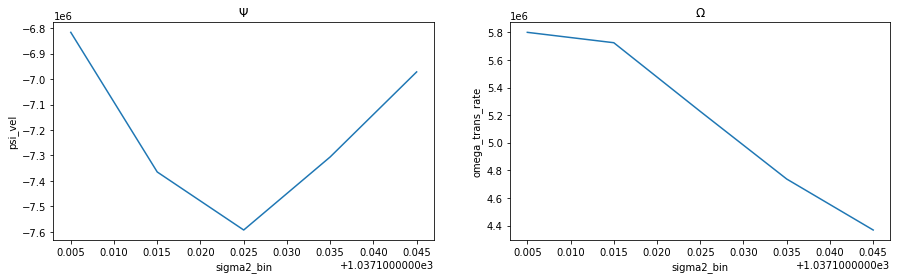

In [6]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.10, 1037.15)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.10, 1037.15)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

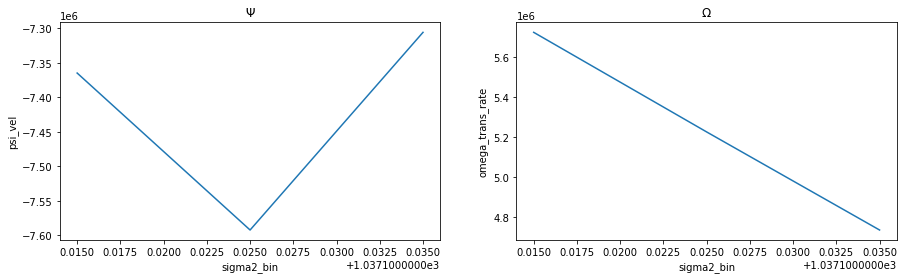

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.11, 1037.14)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.11, 1037.14)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

### $\frac{\partial V}{\partial t}$

In [8]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest'))/1e6
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest') - 
        wmt_budget_terms.mean('time').isel(sigma2_bin=0))/1e6

In [9]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(1.33620132)

In [10]:
bottom.dVdt + deep.dVdt#+ ((wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6)

<xarray.DataArray 'dVdt' ()>
array(-7.74560862e-06)

### E-P-R

### $\Psi$

In [11]:
bottom.psi_vel + deep.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(0.01513492)

### $\Omega$

In [12]:
#deep
omega_deep = (wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6
omega_deep.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(5.22712671)

In [13]:
terms_on_boundary = wmt_budget_terms.sel(sigma2_bin=1037.125, method='nearest')/1e6
terms_on_boundary

<xarray.Dataset>
Dimensions:               (time: 288)
Coordinates:
    sigma2_bin            float64 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/17)
    R1                    (time) float64 nan 0.7447 1.033 ... -3.141 1.045 nan
    R2                    (time) float64 -0.2767 0.09662 0.7604 ... 1.18 0.8101
    dVdt                  (time) float64 nan -9.871 -4.999 ... -8.347 -2.323 nan
    omega_mix             (time) float64 -1.346 -1.768 -2.521 ... -1.851 -2.245
    omega_mix_slt         (time) float64 -0.8965 -0.4581 ... 0.4091 0.4423
    omega_mix_th          (time) float64 -0.4499 -1.31 -2.073 ... -2.26 -2.687
    ...                    ...
    omega_total_th        (time) float64 nan -9.308 -2.996 ... -1.85 0.03565 nan
    omega_trans_rate      (time) float64 nan -0.9404 0.8156 ... 2.272 0.3351 nan
    omega_trans_rate_slt  (time) float64 nan 0.3702 2.889 ... 3.96 2.602 nan
    omega_trans_rate_th   (time) float64 nan -1.311 -2.074 ... -1.688 -2.266 nan
    psi_adv               (time) float64 nan -9.666 -6.839 ... -7.468 -3.673 nan
    psi_vel               (time) float64 nan -9.763 -7.599 ... -9.305 -4.853 nan

In [14]:
omegas = list()
bdy_omegas = list()

for var in terms_on_boundary.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas.append(var)
        bdy_omegas.append(terms_on_boundary.drop('sigma2_bin').data_vars[var])

In [15]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [16]:
bdy_omegas[:1]

[<xarray.DataArray 'omega_mix' (time: 288)>
 array([-1.34638447, -1.76826843, -2.52055532, -2.17451195, -1.34883797,
        -1.40441855, -0.30692953,  0.25287412,  1.06309764,  0.48428811,
         0.67727434,  0.05678597, -0.16788303, -0.13202461,  0.04688955,
         0.022473  ,  0.7085842 ,  0.63425647,  2.04729809,  1.11786585,
         0.94569799,  1.48250748,  0.76262249,  0.89369256,  0.98655011,
         0.55813054,  0.19970743, -1.30134433,  1.33562396,  1.29817334,
         1.46796108,  0.4222553 , -0.1945464 ,  0.25557873,  0.59023924,
         0.92567545, -0.01175897, -0.36483962,  0.01348969, -0.33602888,
        -0.17130963, -0.95040594,  0.20718745, -0.26923023,  0.08195256,
        -0.14675731, -0.84531234, -1.0844723 , -0.94321088, -1.93202842,
        -1.05800788, -0.89293134,  0.05010346, -0.47359163, -0.39144894,
        -0.11062827, -0.5498285 , -0.45598818, -1.06788763, -1.21670607,
        -1.61566374, -1.34442693, -1.03773618, -0.77538772, -1.14938784,
       

In [17]:
len(omegas)

9

In [18]:
len(bdy_omegas)

9

In [19]:
for i in range(9):
    print(bdy_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


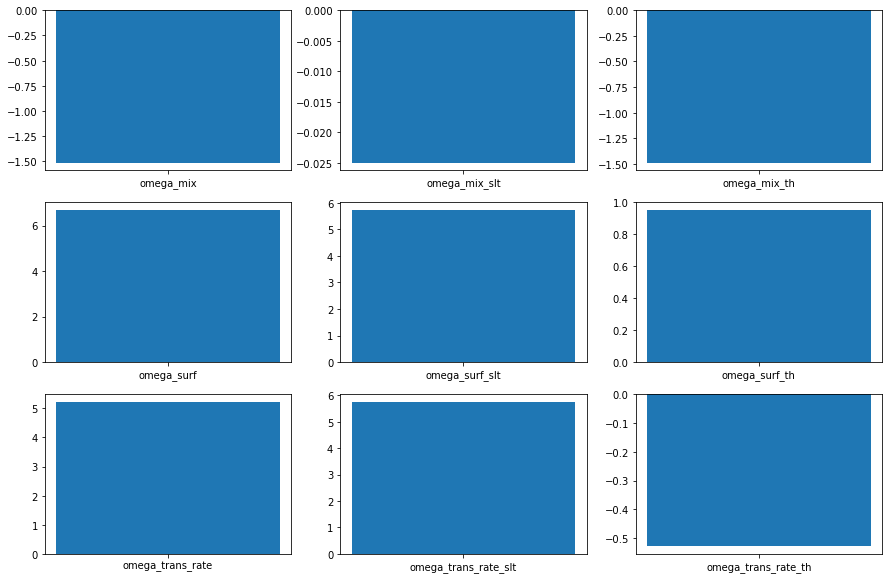

In [20]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=bdy_omegas[i].name, height=bdy_omegas[i].mean('time').values)

In [21]:
- bottom.omega_trans_rate + bottom.omega_mix + bottom.omega_surf

<xarray.DataArray ()>
array(0.04633864)

In [22]:
whole_colmn = wmt_budget_terms.sum('sigma2_bin')/1e6

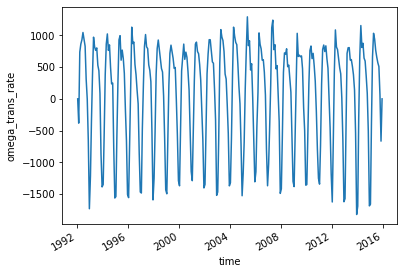

In [23]:
whole_colmn.omega_trans_rate.plot()

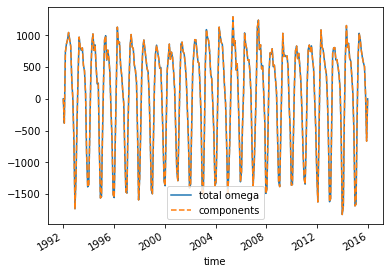

In [24]:
whole_colmn.omega_trans_rate.plot(label='total omega')
(whole_colmn.omega_trans_rate_slt + whole_colmn.omega_trans_rate_th).plot(label='components', linestyle='--')
plt.legend()

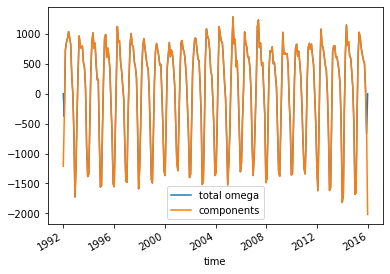

In [25]:
whole_colmn.omega_trans_rate.plot(label='total omega')
(whole_colmn.omega_surf + whole_colmn.omega_mix ).plot(label='components')

plt.legend();

### Budget

* $\frac{\partial V}{\partial t} = \Omega_{total} + R1$ $\Omega_{total} \equiv$ hist(weights=tottend); tottend = $\sigma$.diff(time)*vol / $\Delta$ t
* $\Omega_{trans-rate}$
* $\Psi_{adv} = \Psi_{vel} + R2$
* $R3 = \Omega_{total} - \Psi_{adv} - \Omega_{trans-rate}$
* $\frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1$

__SWITCH SIGN OF ALL TERMS SINCE CUM VOL WAS DEFINED $\int_{\sigma_{max}}^{\sigma_{min}}$ (instead of $\int_{\sigma_{min}}^{\sigma_{max}}$) in wmt budget `poster-figs-sigma-ecco-ts-components-SOSEperiod.ipynb`__

* $\frac{\partial V}{\partial t}$ is (+ to -) for bottom wm, (- to +) for deep wm
   * (No longer cumulative volume!) Decreasing rate of volume means less water in wm; conversely, increasing rate of volume means more water in wm.
* $\Psi$ is (+ to -) for bottom wm, (- to +) for deep wm
   * Negative $\Psi$ means OUTflow, positive $\Psi$ means INflow
* $\Omega$ is (- to +) for bottom wm, (+ to -) for deep wm
   * using only one $\Omega$ (on the boundary) yields a positive value, which means positive transformation of deep layer water being added to bottom layer. (+) into layer 2 (bottom) is trying to add volume, (-) from layer 1 (deep) is trying to remove volume.

In [26]:
print('bottom:', bottom.dVdt.values, ' deep:', deep.dVdt.values)

bottom: 1.3362013187408992  deep: -1.3362090643495177


In [27]:
print('bottom:', bottom.psi_vel.values, ' deep:', deep.psi_vel.values)

bottom: 7.5923920804783664  deep: -7.577257157316621


In [28]:
print('bottom:', bottom.omega_trans_rate.values, ' deep:', deep.omega_trans_rate.values)

bottom: -5.204323343338951  deep: 5.227126705131654


In [29]:
bottom = -bottom
deep = -deep

In [30]:
print('correct bottom:', bottom.dVdt.values, ' correct deep:', deep.dVdt.values)

correct bottom: -1.3362013187408992  correct deep: 1.3362090643495177


In [31]:
print('correct bottom:', bottom.psi_vel.values, ' correct deep:', deep.psi_vel.values)

correct bottom: -7.5923920804783664  correct deep: 7.577257157316621


In [32]:
print('correct bottom:', bottom.omega_trans_rate.values, ', correct deep:', deep.omega_trans_rate.values, ', omega on bdy:', 
      bdy_omegas[6].mean('time').values)

correct bottom: 5.204323343338951 , correct deep: -5.227126705131654 , omega on bdy: 5.227126705131654


### __Bottom budget__

In [33]:
bdy_omegas[6].name

'omega_trans_rate'

In [34]:
- bottom.dVdt + bottom.psi_vel + bottom.R2 + bdy_omegas[6].mean('time') + bottom.R1 

<xarray.DataArray ()>
array(0.03101304)

### __Deep budget__

In [35]:
- deep.dVdt + deep.psi_vel + deep.R2 + deep.omega_trans_rate + deep.R1 

<xarray.DataArray ()>
array(-0.00841902)

In [36]:
- deep.dVdt + deep.psi_vel + deep.R2 - bdy_omegas[6].mean('time') + deep.R1 

<xarray.DataArray ()>
array(-0.00841902)

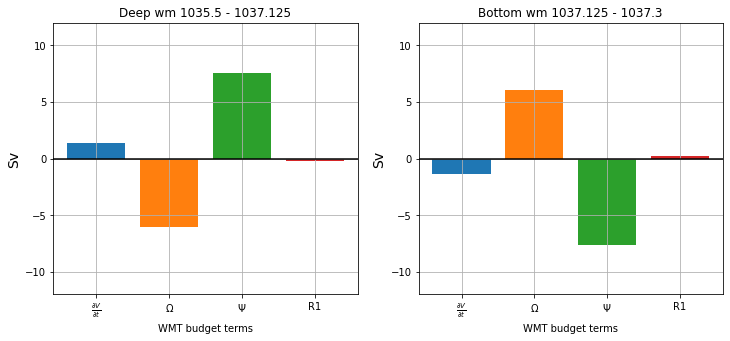

In [37]:
#adding R2 to Omega since R2 reps numerical mixing and Omega is a mixing term
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt)
ax0.bar(x=r'$\Omega$', height = (deep.omega_trans_rate + deep.R2))
ax0.bar(x=r'$\Psi$', height=deep.psi_vel)
#ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1035.5 - 1037.125')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt)
ax1.bar(x=r'$\Omega$', height = (bottom.omega_trans_rate + bottom.R2))
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel)
#ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.125 - 1037.3')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
ax1.set_ylim(-12,12);

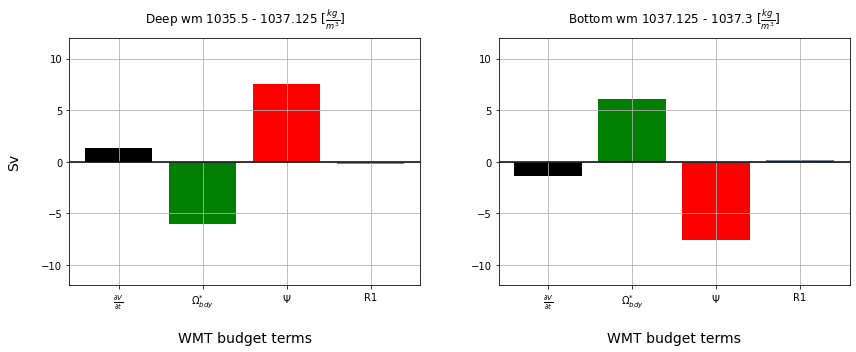

In [38]:
#adding R2 to Omega since R2 reps numerical mixing and Omega is a mixing term
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt, color='k')
ax0.bar(x=r'$\Omega^{*}_{bdy}$', height = (- bdy_omegas[6].mean('time') + deep.R2), color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
#ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1, color='lightslategray')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1035.5 - 1037.125 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14, labelpad=20)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt, color='k')
ax1.bar(x=r'$\Omega^{*}_{bdy}$', height = (bdy_omegas[6].mean('time') + bottom.R2), color='green')
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel, color='red')
#ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1, color='lightslategray')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-12,12)
plt.tight_layout(w_pad=5);

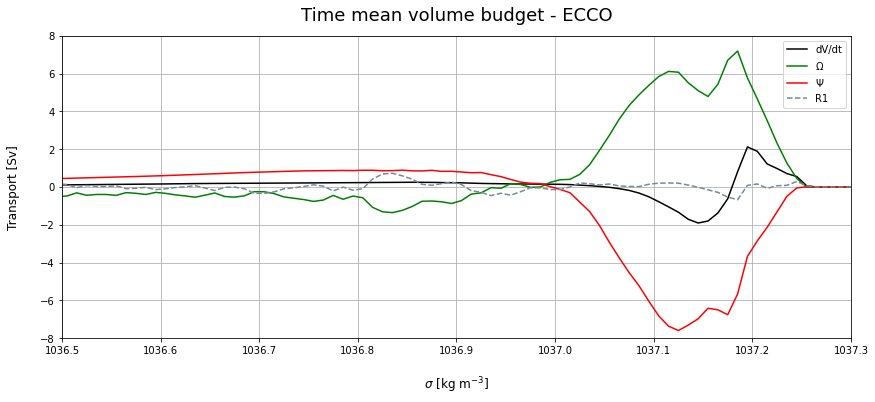

In [39]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
((wmt_budget_terms.omega_trans_rate+wmt_budget_terms.R2)/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 8)
plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title('Time mean volume budget - ECCO', fontsize=18, pad=15);

## Monthly Climatology

In [47]:
def anom(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [48]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'), wmt_budget_terms.R1.rename('R1'), 
                    wmt_budget_terms.psi_vel.rename('psi_vel'), wmt_budget_terms.R2.rename('R2'), 
                    wmt_budget_terms.omega_trans_rate.rename('omega_trans_rate'), 
                    wmt_budget_terms.omega_surf_slt.rename('omega_surf_slt'),
                    wmt_budget_terms.omega_surf_th.rename('omega_surf_th'), 
                    wmt_budget_terms.omega_mix.rename('omega_mix')])


In [55]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [56]:
clim_ds = anom_ds

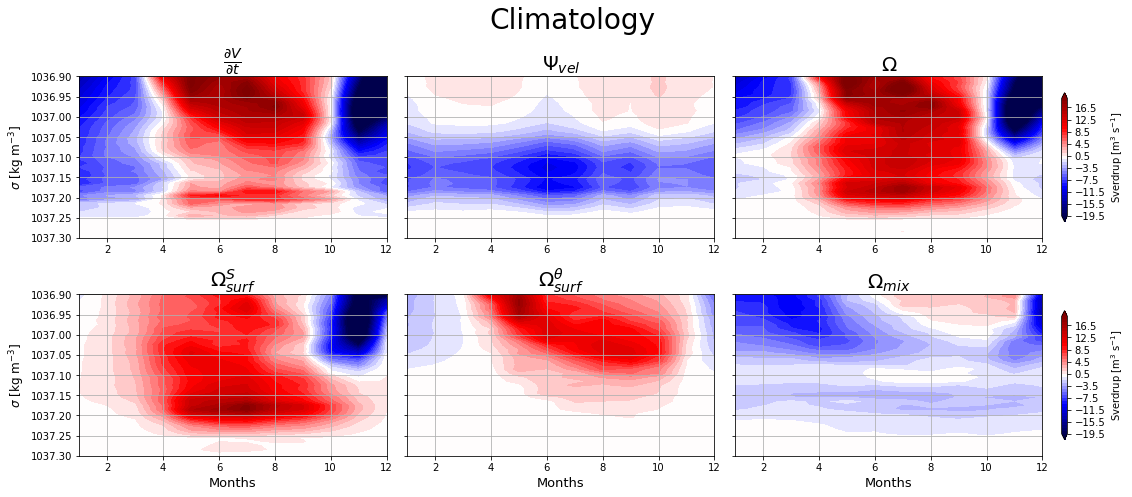

In [57]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036.9)

psi_vel_clim = clim(clim_ds.psi_vel) / 1e6
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[0,1].grid()

omega_clim = clim(clim_ds.omega_trans_rate) /1e6
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].grid()

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)/1e6
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Months', fontsize=13)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].grid()

omega_surf_th_clim = clim(clim_ds.omega_surf_th) /1e6
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
ax[1,1].grid()

omega_mix__clim = clim(clim_ds.omega_mix) / 1e6
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [58]:
dVdt_clim_deep = dVdt_clim.sel(sigma2_bin=1037.125, method='nearest') - dVdt_clim.isel(sigma2_bin=0)
dVdt_clim_deep.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-7.4839335 , -6.39399055, -5.61244903, -2.20099854,  1.83373157,
        2.74867172,  4.88599597,  5.44060096,  3.00471562, -0.46137437,
       -5.70957228, -6.55970729])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [59]:
dVdt_clim_bot = dVdt_clim.isel(sigma2_bin=-1) - dVdt_clim.sel(sigma2_bin=1037.125, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([ 7.48215484,  6.39407244,  5.6143488 ,  2.19915046, -1.83674501,
       -2.74725839, -4.8760114 , -5.44506407, -3.00601537,  0.4633085 ,
        5.70819976,  6.55792863])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

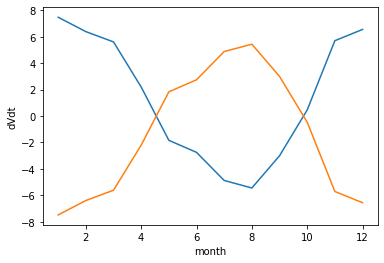

In [60]:
dVdt_clim_bot.plot()
dVdt_clim_deep.plot();

### $\Psi$

In [61]:
psi_clim_deep = psi_vel_clim.sel(sigma2_bin=1037.125, method='nearest') - psi_vel_clim.isel(sigma2_bin=0)
psi_clim_deep.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ -7.71711526,  -6.40043951,  -6.83929015,  -7.43232594,
        -8.94077744, -10.90374841,  -9.99456475,  -6.99082188,
        -7.91375335,  -5.59198039,  -5.65991272,  -6.50344119])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [62]:
psi_clim_bot = psi_vel_clim.isel(sigma2_bin=-1) - psi_vel_clim.sel(sigma2_bin=1037.125, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ 7.77333292,  6.48186549,  6.89889972,  7.49252305,  8.98189952,
       10.8949857 ,  9.99426749,  6.93331363,  7.88714636,  5.56792575,
        5.64203015,  6.52351796])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

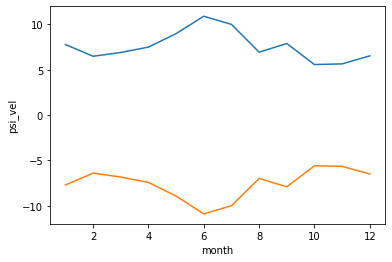

In [63]:
psi_clim_bot.plot()
psi_clim_deep.plot();

### $\Omega$

In [64]:
omega_clim_deep = omega_clim.sel(sigma2_bin=1037.125, method='nearest') - omega_clim.isel(sigma2_bin=0)
omega_clim_deep.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-1.17445213, -0.55905598,  0.4945081 ,  4.39386419,  9.02436265,
       12.85588335, 13.9507894 , 11.02286189,  9.48243781,  4.43851845,
       -0.71264028, -1.01852494])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [65]:
omega_clim_bot = omega_clim.isel(sigma2_bin=-1) - omega_clim.sel(sigma2_bin=1037.125, method='nearest')
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([  1.17276646,   0.55739478,  -0.44846055,  -4.39493732,
        -8.96597284, -12.76508455, -13.85765579, -11.02861212,
        -9.48280118,  -4.43937276,   0.70902156,   1.01675798])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

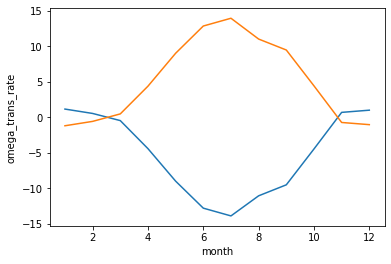

In [66]:
omega_clim_bot.plot()
omega_clim_deep.plot();

In [46]:
omega_clim_bdy = omega_clim.isel(sigma2_bin=-1) - omega_clim.sel(sigma2_bin=1037.125, method='nearest')
omega_clim_bdy.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([  1.17276646,   0.55739478,  -0.44846055,  -4.39493732,
        -8.96597284, -12.76508455, -13.85765579, -11.02861212,
        -9.48280118,  -4.43937276,   0.70902156,   1.01675798])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

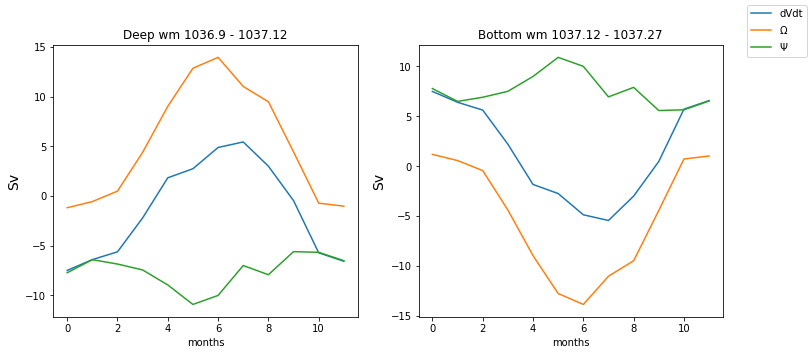

In [48]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_clim_deep, label='dVdt')
ax0.plot(omega_clim_deep, label=r'$\Omega$')
ax0.plot(psi_clim_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_clim_bot)#, label='dVdt')
ax1.plot(omega_clim_bot)#, label=r'$\Omega$')
ax1.plot(psi_clim_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## BOTTOM Monthly Climatology

In [40]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [41]:
#1037.115 to include 1037.125 when slicing
anom_ds = (wmt_budget_terms.sel(sigma2_bin=slice(1037.115, 1037.5)))/1e6

In [42]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [43]:
clim_ds = anom_ds

In [44]:
clim_ds

<xarray.Dataset>
Dimensions:               (sigma2_bin: 37, time: 288)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 -0.2767 -0.2357 ... 0.0 0.0
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 -1.346 -1.418 ... 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 -0.8965 0.2041 ... 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 -0.4499 -1.622 ... 0.0 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

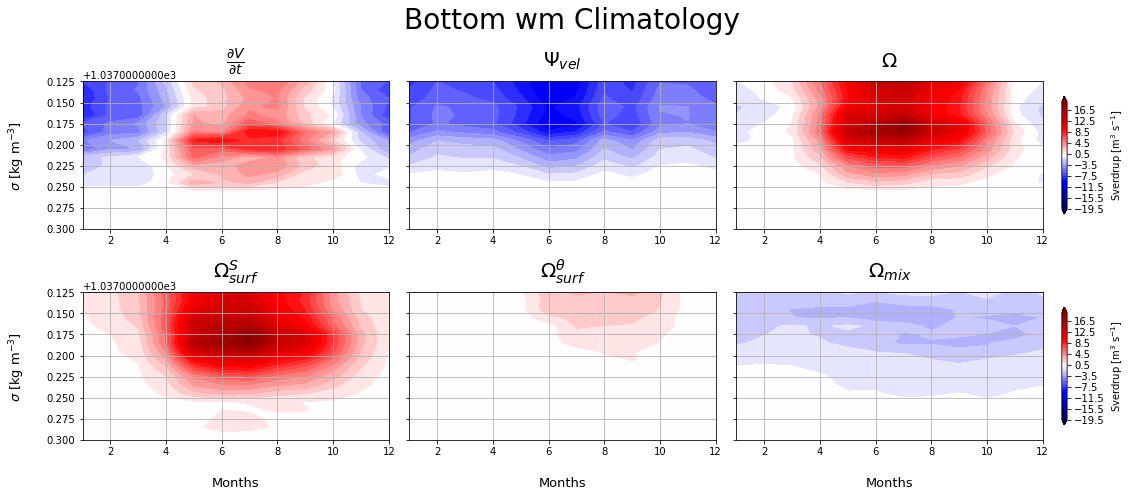

In [45]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt)
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin,
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax[0,1].grid()

omega_clim = (clim(clim_ds.omega_trans_rate) + clim(clim_ds.R2))
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].grid()

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].grid()

omega_surf_th_clim = clim(clim_ds.omega_surf_th)
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax[1,1].grid()

omega_mix__clim = clim(clim_ds.omega_mix)
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].grid()

plt.suptitle('Bottom wm Climatology', fontsize=28)
plt.tight_layout();

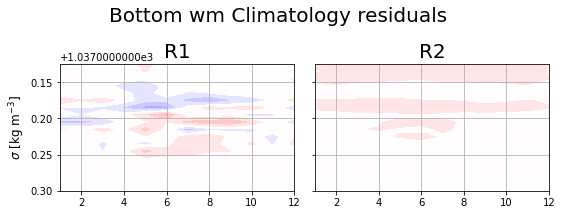

In [46]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

levels = np.arange(-20, 20) + 0.5

R1_clim = clim(clim_ds.R1)
c = ax0.contourf(R1_clim.month, 
                   R1_clim.sigma2_bin,
                   R1_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title('R1', fontsize=20)
ax0.grid()
ax0.set_ylim(1037.3, 1037.125)

R2_clim = clim(clim_ds.R2)
c_psi = ax1.contourf(R2_clim.month, R2_clim.sigma2_bin, R2_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title('R2', fontsize=20)
ax1.grid()


plt.suptitle('Bottom wm Climatology residuals', fontsize=20)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [47]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=0, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-7.48215484, -6.39407244, -5.6143488 , -2.19915046,  1.83674501,
        2.74725839,  4.8760114 ,  5.44506407,  3.00601537, -0.4633085 ,
       -5.70819976, -6.55792863])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

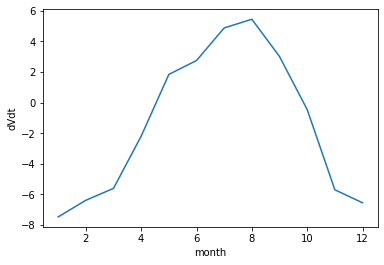

In [48]:
dVdt_clim_bot.plot();

### $\Psi$

In [49]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.isel(sigma2_bin=0)
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ -7.77333292,  -6.48186549,  -6.89889972,  -7.49252305,
        -8.98189952, -10.8949857 ,  -9.99426749,  -6.93331363,
        -7.88714636,  -5.56792575,  -5.64203015,  -6.52351796])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

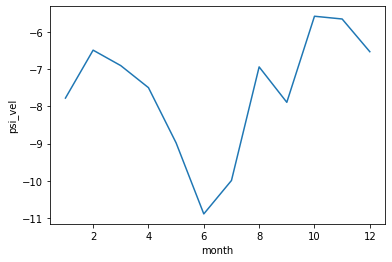

In [50]:
psi_clim_bot.plot();

### $\Omega$

In [51]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [52]:
omega_clim_bot = clim(bdy_omegas[6])
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-1.17445213, -0.55905598,  0.4945081 ,  4.39386419,  9.02436265,
       12.85588335, 13.9507894 , 11.02286189,  9.48243781,  4.43851845,
       -0.71264028, -1.01852494])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [53]:
omega_surf_slt_clim_bot = clim(bdy_omegas[4]).load()
omega_surf_th_clim_bot = clim(bdy_omegas[5]).load()
omega_mix_clim_bot = clim(bdy_omegas[0]).load()

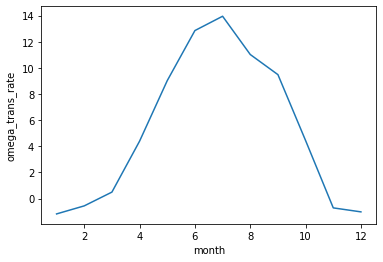

In [54]:
omega_clim_bot.plot();

### Residuals

In [55]:
#remember we are switching signs!
R1_clim_bot = - R1_clim.isel(sigma2_bin=-1) + R1_clim.isel(sigma2_bin=0)
R1_clim_bot.load()

<xarray.DataArray 'R1' (month: 12)>
array([ 0.85131261, -0.01711572, -0.14546284, -0.02347249,  0.80180584,
       -0.069869  ,  0.09331402,  0.26177706,  0.45854789, -0.19109953,
       -0.06258664,  0.50145602])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [56]:
#remember we are switching signs!
R2_clim_bot = - R2_clim.isel(sigma2_bin=-1) + R2_clim.isel(sigma2_bin=0)
R2_clim_bot.load()

<xarray.DataArray 'R2' (month: 12)>
array([0.59435687, 0.68108453, 1.00021411, 0.93935958, 1.06652549,
       0.95292306, 0.92135659, 1.09174011, 0.95361093, 0.86462965,
       0.72292452, 0.5131589 ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### __Bottom climatology budget__

In [57]:
clim_budget = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot + R1_clim_bot + R2_clim_bot
clim_budget

<xarray.DataArray (month: 12)>
array([-0.01996073,  0.01711978,  0.06470846,  0.01637869,  0.07404944,
        0.09669332,  0.09518113, -0.00199863,  0.00143491,  0.00743132,
        0.0138672 ,  0.03050066])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [58]:
clim_bdgt_nores = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot 
clim_bdgt_nores

<xarray.DataArray (month: 12)>
array([-1.46563021, -0.64684903, -0.79004281, -0.8995084 , -1.79428189,
       -0.78636074, -0.91948948, -1.35551581, -1.41072392, -0.66609881,
       -0.64647068, -0.98411427])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

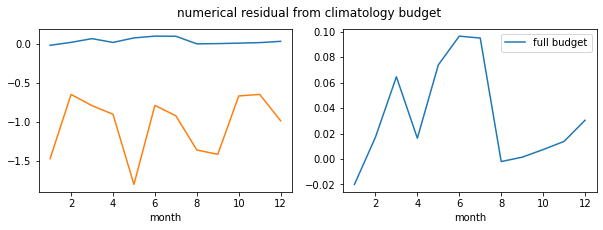

In [59]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
clim_budget.plot(ax=ax0, label='full budget')
clim_bdgt_nores.plot(ax=ax0, label='no residuals')

clim_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from climatology budget');

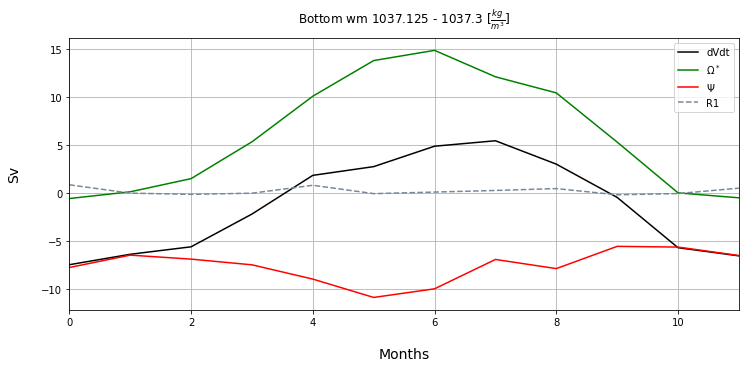

In [60]:
plt.figure(figsize=(12,5))
plt.plot(dVdt_clim_bot, label='dVdt', color='k')
plt.plot((omega_clim_bot+R2_clim_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_clim_bot, label=r'$\Psi$', color='red')
plt.plot(R1_clim_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0,11)

plt.legend()
plt.grid();

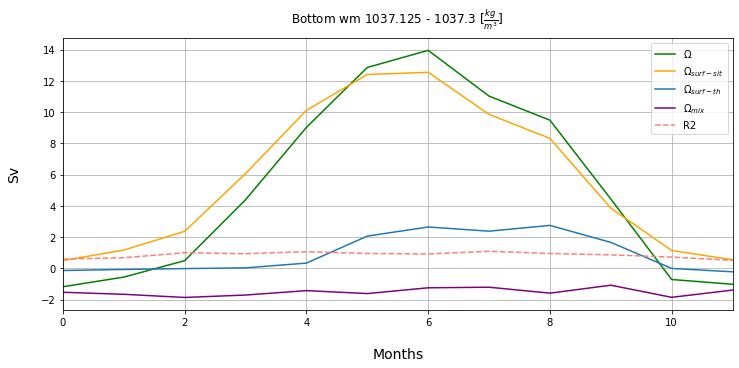

In [61]:
plt.figure(figsize=(12,5))
plt.plot(omega_clim_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_clim_bot, label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_clim_bot, label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_clim_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0,11)
plt.grid()
plt.legend();

In [62]:
omega_clim_bot.mean('month')

<xarray.DataArray 'omega_trans_rate' ()>
array(5.18321271)

In [63]:
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).mean('month')

<xarray.DataArray ()>
array(5.18062971)

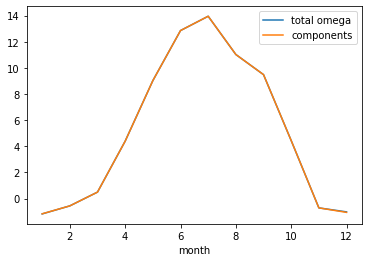

In [64]:
omega_clim_bot.plot(label='total omega')
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).plot(label='components')

plt.legend();

## Anomaly

In [200]:
import warnings
warnings.filterwarnings("ignore")

In [201]:
year_start_index = list(np.arange(0, 23, 5) * 12) #[0, 12, 24, 36, 48, ]

In [ ]:
anom = anom(anom_ds) / 1e6

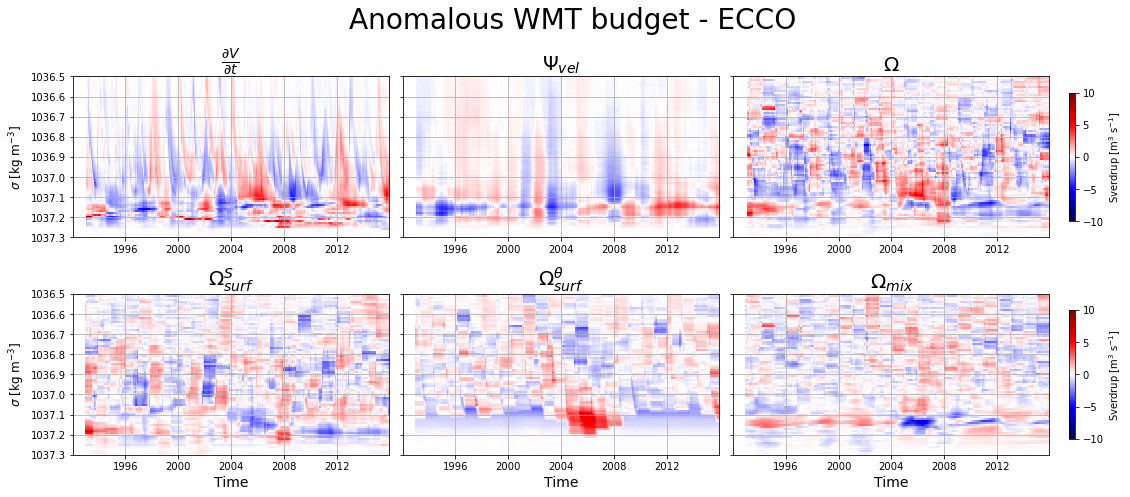

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036.5)

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomalous WMT budget - ECCO', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [53]:
dVdt_anom_deep = anom.dVdt.sel(sigma2_bin=1037.125, method='nearest') - anom.dVdt.isel(sigma2_bin=0)
dVdt_anom_deep.load()

<xarray.DataArray 'dVdt' (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.53871894, -0.08573358, -0.06112693,
       -0.35464882, -0.21046657,  0.22538659,  0.35404104,  0.31951099,
        0.35773553,  0.58847139,  0.26144467,  0.01030308,  0.23856823,
        0.05965705,  0.08594394,  0.3591686 ,  0.28590569, -0.53198634,
       -1.43826547, -1.51612779, -1.92910362, -2.37231403, -2.451993  ,
       -2.32524647, -2.00780477, -1.82033779, -1.98061425, -2.06343607,
       -1.85531532, -1.44291772, -1.43979033, -1.48433214, -1.2421925 ,
       -1.06968544, -0.89477936, -0.56367278, -0.61308232, -0.78276829,
       -0.67787001, -0.44018314, -0.34838273, -0.79940755, -0.1959862 ,
       -0.68947048, -1.17901609, -0.93835847, -0.83895369, -1.35692532,
       -1.72575934, -1.93640004, -1.72773728, -2.48164735, -3.01524838,
       -2.57456754, -2.66128109, -2.1577906 , -1.53299299, -1.95466382,
       -1.75297137, -1.72844208, -1.54015456, -1.40666988, -1.58017   ,
       -0.47998289,  0.40567203,  0.98661275,  1.53491268,  1.65252453,
        2.10166813,  2.44092591,  1.99949051,  2.41379798,  2.66593242,
        2.72049524,  2.52576808,  1.72827608,  1.23770572, -0.0487231 ,
       -0.7769311 , -0.73889857, -1.05702406, -1.16496232, -0.91115832,
       -0.846342  , -0.99530088, -1.19352706, -1.36644421, -1.22042343,
...
        1.31312573,  1.37942087,  1.75703863,  1.90978922,  1.64638406,
        1.57478244,  0.88682767,  0.56070853, -0.56660035, -0.63876747,
       -1.62203702, -0.9043618 ,  0.48408287,  0.89740403,  1.04430113,
        0.96815917,  0.87762549,  1.03296649,  1.14785695,  0.76569596,
        0.6762631 ,  0.04724942, -0.02996421, -0.35394504, -0.46472302,
       -0.61124513, -1.20085532, -1.31729673, -1.52847713, -1.77376866,
       -1.6954504 , -2.09111778, -1.8620148 , -1.49935403, -1.13385946,
       -1.13270002, -1.13346241, -1.4946603 , -1.58778891, -1.14960123,
       -1.02475145, -1.25833185, -1.27455652, -1.42944226, -1.73007036,
       -1.66020625, -1.53407154, -1.03967071, -1.30727173, -0.59204296,
        0.39616123,  0.84550464,  1.40935911,  2.06964907,  2.54687844,
        3.7916309 ,  4.09435241,  4.40094547,  4.42221383,  4.25058059,
        4.42513063,  4.09141748,  3.92626312,  3.77331589,  4.05004282,
        4.13253065,  4.1111155 ,  3.45388004,  3.2986825 ,  2.75024592,
        2.56763929,  2.28642582,  2.47860846,  2.81103181,  2.29369088,
        1.86225424,  1.14205074,  0.93108208,  0.23117337,  0.24935154,
        0.24488418,  0.35647571, -0.16665429, -0.40936783, -0.48918435,
       -0.86768694, -0.50284072, -0.31039855,  0.06297369,  0.19679058,
        0.70616519,  0.89331145,  0.96437665,  1.39505148,  2.64258699,
        2.11627586,  2.10146285,         nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [54]:
dVdt_anom_bot = anom.dVdt.isel(sigma2_bin=-1) - anom.dVdt.sel(sigma2_bin=1037.125, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        5.43334435e-01,  9.12876578e-02,  6.27570649e-02,  3.54078455e-01,
        2.10424652e-01, -2.24552492e-01, -3.38899757e-01, -3.04535024e-01,
       -3.42759564e-01, -5.83870668e-01, -2.53761900e-01, -7.52690334e-04,
       -2.29017848e-01, -5.10452486e-02, -7.34081992e-02, -3.44102413e-01,
       -2.70519471e-01,  5.45289837e-01,  1.43694280e+00,  1.51528942e+00,
        1.92826525e+00,  2.37232340e+00,  2.45200237e+00,  2.32525584e+00,
        2.00781415e+00,  1.82034717e+00,  1.98062363e+00,  2.06256944e+00,
        1.85412865e+00,  1.44293777e+00,  1.43981037e+00,  1.48435218e+00,
        1.24221255e+00,  1.06970548e+00,  8.94799399e-01,  5.63692827e-01,
        6.13102367e-01,  7.82788337e-01,  6.77890051e-01,  4.41579627e-01,
        3.48447175e-01,  7.99471993e-01,  1.96050649e-01,  6.89534925e-01,
        1.17908053e+00,  9.38422915e-01,  8.39018137e-01,  1.35698976e+00,
        1.72582378e+00,  1.93439677e+00,  1.72760162e+00,  2.48013525e+00,
        3.01320070e+00,  2.57086543e+00,  2.65944660e+00,  2.15288321e+00,
        1.52490687e+00,  1.94172745e+00,  1.74037202e+00,  1.71584273e+00,
        1.52568759e+00,  1.39427063e+00,  1.56675088e+00,  4.66733509e-01,
       -4.16606224e-01, -9.89919953e-01, -1.53254682e+00, -1.64687630e+00,
...
       -1.14783690e+00, -7.65675914e-01, -6.77090806e-01, -4.72293767e-02,
        2.99842503e-02,  3.53965081e-01,  4.64743062e-01,  6.11265170e-01,
        1.20087536e+00,  1.31731678e+00,  1.52849717e+00,  1.77378870e+00,
        1.69547044e+00,  2.09113782e+00,  1.86203484e+00,  1.49937408e+00,
        1.13387950e+00,  1.13272006e+00,  1.13348245e+00,  1.49468034e+00,
        1.58780896e+00,  1.14962127e+00,  1.02477149e+00,  1.25835189e+00,
        1.27457656e+00,  1.42946231e+00,  1.73040939e+00,  1.66107405e+00,
        1.53406333e+00,  1.03966250e+00,  1.30726351e+00,  5.92034741e-01,
       -3.96169442e-01, -8.45512855e-01, -1.40936733e+00, -2.06965729e+00,
       -2.54688666e+00, -3.79163911e+00, -4.09467960e+00, -4.40180144e+00,
       -4.42219379e+00, -4.25056055e+00, -4.42511059e+00, -4.09139744e+00,
       -3.92624308e+00, -3.77329584e+00, -4.04917502e+00, -4.13253886e+00,
       -4.10979167e+00, -3.45393266e+00, -3.29873511e+00, -2.75029854e+00,
       -2.56769190e+00, -2.28647843e+00, -2.47866107e+00, -2.81108442e+00,
       -2.29374350e+00, -1.86230685e+00, -1.14295110e+00, -9.31106442e-01,
       -2.32529772e-01, -2.49331495e-01, -2.44864137e-01, -3.56455668e-01,
        1.66674334e-01,  4.09387873e-01,  4.89204392e-01,  8.67706985e-01,
        5.02860768e-01,  3.10418589e-01, -6.29536511e-02, -1.96770538e-01,
       -7.06145146e-01, -8.93291401e-01, -9.64356604e-01, -1.39503144e+00,
       -2.64256694e+00, -2.11625582e+00, -2.10144281e+00,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

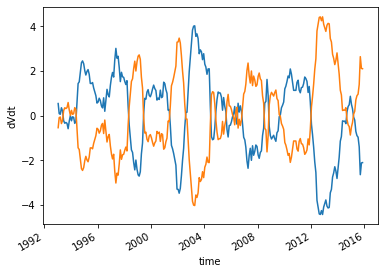

In [55]:
dVdt_anom_bot.plot()
dVdt_anom_deep.plot();

### $\Psi$

In [56]:
psi_anom_deep = anom.psi_vel.sel(sigma2_bin=1037.125, method='nearest') - anom.psi_vel.isel(sigma2_bin=0)
psi_anom_deep.load()

<xarray.DataArray 'psi_vel' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -1.24624846e+00, -1.02749151e+00, -9.94845080e-01, -1.19057606e+00,
       -8.17885588e-01, -2.17886221e-01,  1.24649941e-01,  3.01042632e-01,
        1.93694050e-02,  1.41479326e-01, -1.46071686e-01, -4.12381455e-01,
       -2.10180312e-01, -3.55265207e-01, -3.13378041e-01, -4.54398566e-01,
       -7.06620509e-01, -1.34926283e+00, -2.15176936e+00, -2.10648429e+00,
       -2.13933899e+00, -2.54690066e+00, -2.72239065e+00, -2.55185232e+00,
       -2.39175281e+00, -2.22975560e+00, -2.31605833e+00, -2.03032714e+00,
       -1.72272936e+00, -1.11357269e+00, -1.10905423e+00, -1.26657907e+00,
       -1.09140819e+00, -7.12221381e-01, -3.50296705e-01, -6.08610231e-02,
       -6.87175031e-02, -4.32204568e-02,  1.29741227e-01, -2.18571728e-02,
       -1.50997109e-01, -6.59463993e-01, -4.02294345e-03, -9.76282730e-02,
       -4.89302121e-01, -3.01647470e-01, -3.33995829e-01, -6.05700604e-01,
       -6.67231921e-01, -7.76682604e-01, -5.52624983e-01, -5.80361868e-01,
       -5.65732310e-01, -2.60929345e-01, -4.44443880e-01, -9.88375093e-02,
        3.95829845e-01, -3.13589899e-01, -1.43962608e-01, -4.45826564e-01,
       -7.09273006e-01, -7.04556765e-01, -1.10517929e+00, -5.54534333e-01,
       -1.61574532e-01, -8.95363899e-02,  1.26379877e-01, -4.91160352e-03,
...
        1.31768950e+00,  1.21143343e+00,  9.70756350e-01,  1.91709805e-01,
       -3.85366795e-02,  8.33828864e-02, -4.16679272e-02, -3.58639738e-01,
       -8.40354098e-01, -1.01463947e+00, -9.36789490e-01, -7.19473584e-01,
       -6.71140777e-01, -6.44252643e-01, -4.13612618e-01,  9.15717962e-02,
        6.52351984e-01,  6.97574373e-01,  9.67986219e-01,  9.97317125e-01,
        1.21559735e+00,  1.87586766e+00,  2.03427131e+00,  2.32554862e+00,
        2.72350753e+00,  2.64444747e+00,  2.56302422e+00,  2.47848585e+00,
        2.00096567e+00,  2.18443459e+00,  1.64351582e+00,  2.11283792e+00,
        2.61760928e+00,  2.71821581e+00,  2.82461948e+00,  2.58923806e+00,
        2.35354946e+00,  3.02134084e+00,  3.17222765e+00,  3.62338830e+00,
        3.96380228e+00,  3.82061092e+00,  4.04781266e+00,  3.64146216e+00,
        3.45497413e+00,  3.19456951e+00,  3.30101240e+00,  3.39792928e+00,
        3.47932639e+00,  2.90409620e+00,  2.89282311e+00,  2.39788041e+00,
        2.23645513e+00,  1.85657187e+00,  2.00832217e+00,  2.22147330e+00,
        1.81675178e+00,  1.48931287e+00,  1.07436725e+00,  1.00528006e+00,
        6.93536288e-01,  6.34532850e-01,  4.42451832e-01,  4.97837744e-01,
        1.05052881e-01,  1.93007756e-02, -4.49551424e-02, -4.81319654e-01,
       -2.39451096e-01,  5.32385230e-02,  2.65784175e-01,  2.13126955e-01,
        3.87501747e-01,  4.31817624e-01,  7.29674890e-01,  9.72440346e-01,
        1.68918709e+00,  1.55488106e+00,  1.52810903e+00,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [57]:
psi_anom_bot = anom.psi_vel.isel(sigma2_bin=-1) - anom.psi_vel.sel(sigma2_bin=1037.125, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  1.2093939 ,  0.99195637,  0.95455431,
        1.15134394,  0.78911143,  0.20810115, -0.14034581, -0.31037459,
       -0.02500025, -0.15343762,  0.14411749,  0.41122434,  0.21028369,
        0.36202015,  0.32301849,  0.4651086 ,  0.70690622,  1.34096924,
        2.14748761,  2.10625013,  2.14110426,  2.55269755,  2.73115204,
        2.56684125,  2.39530756,  2.23012121,  2.31755396,  2.03343024,
        1.74476726,  1.129401  ,  1.11781088,  1.28214029,  1.10408356,
        0.72125814,  0.35882961,  0.05971936,  0.07437863,  0.0534045 ,
       -0.12076479,  0.02854283,  0.15831862,  0.66147414,  0.01830524,
        0.10253527,  0.50006087,  0.32550251,  0.35753781,  0.6367363 ,
        0.69574378,  0.80702774,  0.59210248,  0.61366239,  0.59603868,
        0.28857244,  0.47278982,  0.11917704, -0.3829378 ,  0.31724532,
        0.13574317,  0.42617868,  0.69450023,  0.6817679 ,  1.07890876,
        0.53079902,  0.1255376 ,  0.06167469, -0.1638527 , -0.01806941,
       -0.00502329, -0.36055538,  0.12980261, -0.48921928, -0.76299972,
       -0.71717003, -0.58044391, -0.07570818,  0.11022022,  0.46502811,
        0.7147992 ,  0.50795599,  0.57178058,  0.29249443, -0.27257817,
       -0.22322361, -0.39627933, -0.39658391, -0.33164397, -0.20024712,
...
        2.01899762,  1.89929546,  1.65760094,  1.64289486,  1.74780852,
        1.60903461,  1.4719073 ,  1.28863445,  0.43492658, -0.12299681,
       -0.38259894, -0.62351961, -1.03112346, -1.29600021, -1.2783611 ,
       -1.28242312, -1.23427514, -1.17885856, -1.32459058, -1.21996627,
       -0.96953197, -0.19186932,  0.05399511, -0.06334022,  0.05640175,
        0.36670198,  0.85344573,  1.03292576,  0.95493913,  0.73682616,
        0.68657646,  0.6585909 ,  0.42983136, -0.0842192 , -0.66250439,
       -0.70654762, -0.97701779, -1.00211017, -1.22310596, -1.8772374 ,
       -2.03472833, -2.32102845, -2.72084415, -2.63543692, -2.56253634,
       -2.46816691, -1.97920945, -2.17235435, -1.62172742, -2.09886768,
       -2.60369821, -2.71303465, -2.82473269, -2.59227297, -2.35196134,
       -3.03101866, -3.17107021, -3.61725709, -3.96377505, -3.82066757,
       -4.05486825, -3.64993651, -3.46080866, -3.20272674, -3.29902419,
       -3.40325224, -3.4874593 , -2.90323178, -2.8885904 , -2.39100528,
       -2.23416905, -1.84711856, -1.9989441 , -2.20530268, -1.80432625,
       -1.46810607, -1.06390976, -0.99036464, -0.6808942 , -0.62574581,
       -0.43825856, -0.50200525, -0.10054851, -0.01847915,  0.03574176,
        0.47525783,  0.22930808, -0.06863722, -0.27239198, -0.2232121 ,
       -0.39435269, -0.43740309, -0.74394535, -0.98047945, -1.70530617,
       -1.56771467, -1.53063835,         nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

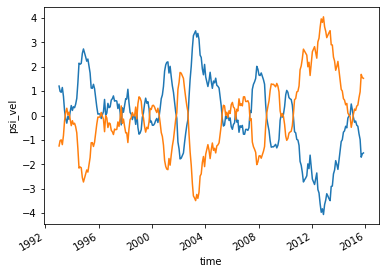

In [58]:
psi_anom_bot.plot()
psi_anom_deep.plot();

### $\Omega$

In [59]:
omega_anom_deep = anom.omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest') - anom.omega_trans_rate.isel(sigma2_bin=0)
omega_anom_deep.load()

<xarray.DataArray 'omega_trans_rate' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        1.96443654e+00,  2.15542159e+00,  2.26818886e+00,  2.30320339e+00,
        2.19685625e+00,  1.93630974e+00,  1.61171344e+00,  1.15225830e+00,
        1.29864347e+00,  1.35011307e+00,  1.23465589e+00,  1.28802594e+00,
        1.34756601e+00,  1.38277810e+00,  1.41032687e+00,  1.61636766e+00,
        1.72108848e+00,  1.59887290e+00,  1.59323827e+00,  1.54287672e+00,
        1.14017282e+00,  1.07262939e+00,  1.11030373e+00,  1.13271110e+00,
        1.05191838e+00,  9.58644040e-01,  8.74363532e-01,  6.20205486e-01,
        5.04678252e-01,  2.60962189e-01,  1.74599830e-01,  2.88978292e-01,
        3.50440025e-01,  1.52932264e-01,  5.91648432e-02, -1.16429478e-01,
       -1.82503982e-01, -2.95401877e-01, -3.28995835e-01, -4.85710950e-02,
        7.18854912e-02,  3.13071641e-01,  1.73234528e-01, -1.68456830e-01,
       -3.46601413e-01, -3.40817295e-01, -3.71859193e-01, -3.78200874e-01,
       -4.44121800e-01, -4.38833664e-01, -4.59382626e-01, -9.43279950e-01,
       -1.34123609e+00, -1.34269390e+00, -1.14778859e+00, -1.01748719e+00,
       -7.13962144e-01, -3.53688116e-01, -1.24675688e-01,  1.03878160e-01,
        3.33092438e-01,  6.27933198e-01,  8.07209329e-01,  1.13115233e+00,
        1.54472017e+00,  2.02378169e+00,  2.05192227e+00,  2.26917226e+00,
...
        4.48479665e-02, -2.32827622e-01, -5.13222874e-02,  4.38769658e-03,
       -1.29927821e-02, -5.20042069e-01, -7.05994136e-01, -1.05416492e+00,
       -1.41843596e+00, -1.70346433e+00, -1.95236012e+00, -2.37280123e+00,
       -2.43025668e+00, -2.83807819e+00, -3.06472725e+00, -3.36749904e+00,
       -3.71852036e+00, -3.80296347e+00, -4.01156056e+00, -4.12316120e+00,
       -4.18380051e+00, -4.23238486e+00, -4.26610290e+00, -4.37316088e+00,
       -4.71920994e+00, -4.64541754e+00, -4.57040636e+00, -4.31551477e+00,
       -3.90777536e+00, -3.61070813e+00, -3.25455815e+00, -2.77690755e+00,
       -2.27836814e+00, -1.80968558e+00, -1.46019039e+00, -7.91587403e-01,
       -1.55368490e-01,  4.92557836e-01,  6.00185233e-01,  6.07922872e-01,
        7.78132187e-01,  9.06050866e-01,  9.01985431e-01,  8.59732865e-01,
        8.02403573e-01,  7.64046128e-01,  9.58726684e-01,  9.41677449e-01,
        9.27984065e-01,  6.06433637e-01,  4.79956840e-01,  3.59195811e-01,
        2.18037972e-01,  2.88450672e-01,  3.73352141e-01,  3.56944086e-01,
        3.46164721e-01,  2.89518936e-01, -2.95854930e-02, -3.31341038e-01,
       -8.41499127e-01, -8.91463539e-01, -9.66603529e-01, -7.21766618e-01,
       -8.52972162e-01, -1.09533163e+00, -1.26872669e+00, -1.37297198e+00,
       -1.57051008e+00, -1.78778819e+00, -1.84343548e+00, -1.50526514e+00,
       -1.24641512e+00, -1.08732494e+00, -9.27109834e-01, -1.00894647e+00,
       -5.08415293e-01, -6.31289320e-01, -5.70982340e-01,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [60]:
omega_anom_bot = anom.omega_trans_rate.isel(sigma2_bin=-1) - anom.omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest')
omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -1.92886768e+00, -2.12011535e+00, -2.23298858e+00, -2.26800311e+00,
       -2.16165597e+00, -1.83185250e+00, -1.44097579e+00, -9.75720341e-01,
       -1.12194933e+00, -1.17341893e+00, -1.05758490e+00, -1.11057945e+00,
       -1.16993913e+00, -1.20496808e+00, -1.23255580e+00, -1.43791758e+00,
       -1.54263841e+00, -1.48967978e+00, -1.60954026e+00, -1.56497902e+00,
       -1.16243129e+00, -1.09488787e+00, -1.13256220e+00, -1.15496958e+00,
       -1.07409679e+00, -9.80742958e-01, -8.96317547e-01, -6.42838503e-01,
       -5.27311268e-01, -2.83595206e-01, -1.97232847e-01, -3.11611309e-01,
       -3.73073042e-01, -1.75565281e-01, -8.17978600e-02,  9.37964607e-02,
        1.59870965e-01,  2.72672583e-01,  3.05974801e-01,  2.51373087e-02,
       -9.55895293e-02, -3.37373091e-01, -1.98121657e-01,  1.42985013e-01,
        3.20556253e-01,  3.14208377e-01,  3.44683091e-01,  3.50458295e-01,
        4.15815253e-01,  4.10054451e-01,  4.30319756e-01,  9.14046104e-01,
        1.31174093e+00,  1.31326339e+00,  1.11851266e+00,  9.88283114e-01,
        6.85006079e-01,  3.25083830e-01,  9.66385863e-02, -1.31478403e-01,
       -3.60128713e-01, -6.54400529e-01, -8.33101263e-01, -1.15646054e+00,
       -1.57610527e+00, -1.93983631e+00, -1.96328407e+00, -2.19418873e+00,
...
       -6.74809834e-02,  2.10194605e-01,  2.86892706e-02, -2.70207134e-02,
       -9.64023480e-03,  4.97409053e-01,  6.83361119e-01,  1.03153191e+00,
        1.39580295e+00,  1.68083131e+00,  1.92972710e+00,  2.35016821e+00,
        2.40762366e+00,  2.81544518e+00,  3.04209423e+00,  3.34486602e+00,
        3.69588735e+00,  3.78033045e+00,  3.98892754e+00,  4.10052818e+00,
        4.16116750e+00,  4.20975184e+00,  4.24346988e+00,  4.35052786e+00,
        4.69657692e+00,  4.62278452e+00,  4.54777334e+00,  4.29288176e+00,
        3.88514235e+00,  3.58807512e+00,  3.23192513e+00,  2.75427453e+00,
        2.25573513e+00,  1.78705256e+00,  1.43755737e+00,  7.68954386e-01,
        1.32735473e-01, -5.15190853e-01, -6.22818250e-01, -6.30555889e-01,
       -8.00765203e-01, -9.28683883e-01, -9.24618448e-01, -8.82365882e-01,
       -8.25036590e-01, -7.86679145e-01, -8.92515621e-01, -8.75466386e-01,
       -8.61773002e-01, -5.40222574e-01, -4.13745777e-01, -2.92984748e-01,
       -1.51826909e-01, -2.22239609e-01, -3.07141078e-01, -2.90733023e-01,
       -2.79953658e-01, -2.23307872e-01,  6.95247610e-03,  3.08708021e-01,
        8.18866110e-01,  8.68830522e-01,  9.43926840e-01,  6.98995208e-01,
        8.30455144e-01,  1.07281462e+00,  1.24620967e+00,  1.35045496e+00,
        1.54794864e+00,  1.76513271e+00,  1.82068405e+00,  1.48241745e+00,
        1.22371527e+00,  1.06520934e+00,  9.05531440e-01,  9.87462796e-01,
        4.86677227e-01,  6.09551255e-01,  5.49244274e-01,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

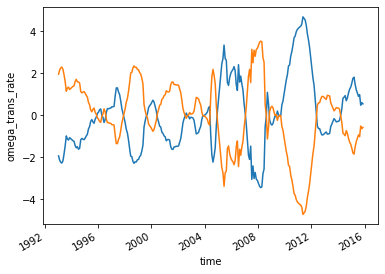

In [61]:
omega_anom_bot.plot()
omega_anom_deep.plot();

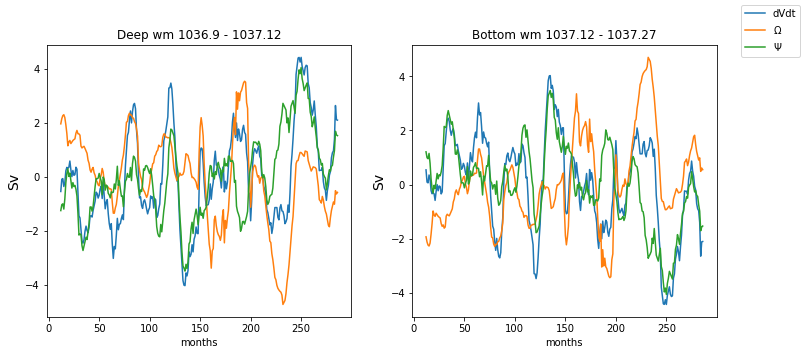

In [62]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_anom_deep, label='dVdt')
ax0.plot(omega_anom_deep, label=r'$\Omega$')
ax0.plot(psi_anom_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_anom_bot)#, label='dVdt')
ax1.plot(omega_anom_bot)#, label=r'$\Omega$')
ax1.plot(psi_anom_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## BOTTOM Anomaly

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
year_start_index = list(np.arange(0, 23, 5) * 12) #[0, 12, 24, 36, 48, ]

In [67]:
anom = anomaly(anom_ds)

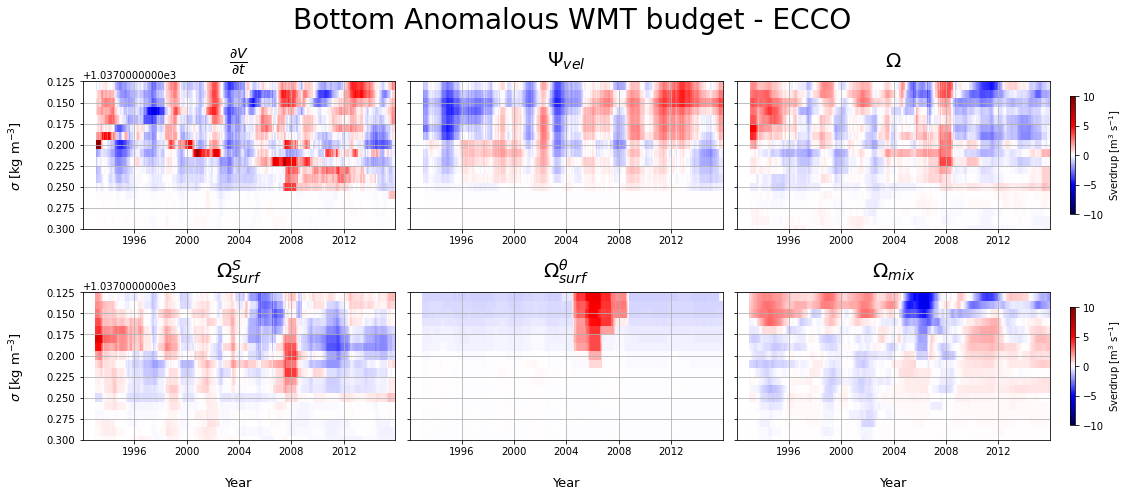

In [68]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Bottom Anomalous WMT budget - ECCO', fontsize=28)
plt.tight_layout();

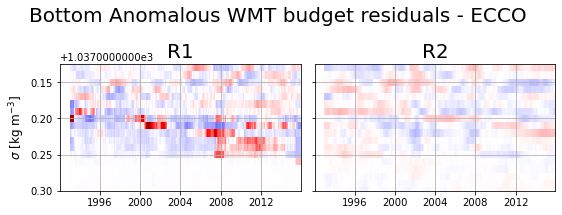

In [69]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

R1_anom = ax0.pcolormesh(anom.R1.time.values, 
                   anom.R1.sigma2_bin, 
                   anom.R1.T, vmin=-10, vmax=10, cmap='seismic')
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax0.set_title('R1', fontsize=20)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax0.grid()
ax0.set_ylim(1037.3, 1037.125)

R2_anom = ax1.pcolormesh(anom.R2.time.values, anom.R2.sigma2_bin, anom.R2.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax1.set_title('R2', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax1.grid()

plt.suptitle('Bottom Anomalous WMT budget residuals - ECCO', fontsize=20)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [70]:
#remember we're switching signs!
dVdt_anom_bot = - anom.dVdt.isel(sigma2_bin=-1) + anom.dVdt.isel(sigma2_bin=0)
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -5.43334435e-01, -9.12876578e-02, -6.27570649e-02, -3.54078455e-01,
       -2.10424652e-01,  2.24552492e-01,  3.38899757e-01,  3.04535024e-01,
        3.42759564e-01,  5.83870668e-01,  2.53761900e-01,  7.52690334e-04,
        2.29017848e-01,  5.10452486e-02,  7.34081992e-02,  3.44102413e-01,
        2.70519471e-01, -5.45289837e-01, -1.43694280e+00, -1.51528942e+00,
       -1.92826525e+00, -2.37232340e+00, -2.45200237e+00, -2.32525584e+00,
       -2.00781415e+00, -1.82034717e+00, -1.98062363e+00, -2.06256944e+00,
       -1.85412865e+00, -1.44293777e+00, -1.43981037e+00, -1.48435218e+00,
       -1.24221255e+00, -1.06970548e+00, -8.94799399e-01, -5.63692827e-01,
       -6.13102367e-01, -7.82788337e-01, -6.77890051e-01, -4.41579627e-01,
       -3.48447175e-01, -7.99471993e-01, -1.96050649e-01, -6.89534925e-01,
       -1.17908053e+00, -9.38422915e-01, -8.39018137e-01, -1.35698976e+00,
       -1.72582378e+00, -1.93439677e+00, -1.72760162e+00, -2.48013525e+00,
       -3.01320070e+00, -2.57086543e+00, -2.65944660e+00, -2.15288321e+00,
       -1.52490687e+00, -1.94172745e+00, -1.74037202e+00, -1.71584273e+00,
       -1.52568759e+00, -1.39427063e+00, -1.56675088e+00, -4.66733509e-01,
        4.16606224e-01,  9.89919953e-01,  1.53254682e+00,  1.64687630e+00,
...
        1.14783690e+00,  7.65675914e-01,  6.77090806e-01,  4.72293767e-02,
       -2.99842503e-02, -3.53965081e-01, -4.64743062e-01, -6.11265170e-01,
       -1.20087536e+00, -1.31731678e+00, -1.52849717e+00, -1.77378870e+00,
       -1.69547044e+00, -2.09113782e+00, -1.86203484e+00, -1.49937408e+00,
       -1.13387950e+00, -1.13272006e+00, -1.13348245e+00, -1.49468034e+00,
       -1.58780896e+00, -1.14962127e+00, -1.02477149e+00, -1.25835189e+00,
       -1.27457656e+00, -1.42946231e+00, -1.73040939e+00, -1.66107405e+00,
       -1.53406333e+00, -1.03966250e+00, -1.30726351e+00, -5.92034741e-01,
        3.96169442e-01,  8.45512855e-01,  1.40936733e+00,  2.06965729e+00,
        2.54688666e+00,  3.79163911e+00,  4.09467960e+00,  4.40180144e+00,
        4.42219379e+00,  4.25056055e+00,  4.42511059e+00,  4.09139744e+00,
        3.92624308e+00,  3.77329584e+00,  4.04917502e+00,  4.13253886e+00,
        4.10979167e+00,  3.45393266e+00,  3.29873511e+00,  2.75029854e+00,
        2.56769190e+00,  2.28647843e+00,  2.47866107e+00,  2.81108442e+00,
        2.29374350e+00,  1.86230685e+00,  1.14295110e+00,  9.31106442e-01,
        2.32529772e-01,  2.49331495e-01,  2.44864137e-01,  3.56455668e-01,
       -1.66674334e-01, -4.09387873e-01, -4.89204392e-01, -8.67706985e-01,
       -5.02860768e-01, -3.10418589e-01,  6.29536511e-02,  1.96770538e-01,
        7.06145146e-01,  8.93291401e-01,  9.64356604e-01,  1.39503144e+00,
        2.64256694e+00,  2.11625582e+00,  2.10144281e+00,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

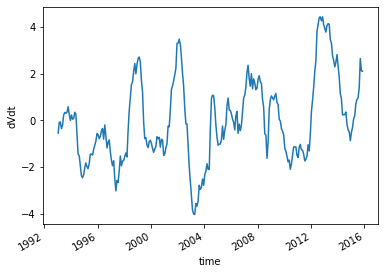

In [71]:
dVdt_anom_bot.plot();

### $\Psi$

In [72]:
#remember we're switching signs!
psi_anom_bot = - anom.psi_vel.isel(sigma2_bin=-1) + anom.psi_vel.sel(sigma2_bin=1037.125, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.2093939 , -0.99195637, -0.95455431,
       -1.15134394, -0.78911143, -0.20810115,  0.14034581,  0.31037459,
        0.02500025,  0.15343762, -0.14411749, -0.41122434, -0.21028369,
       -0.36202015, -0.32301849, -0.4651086 , -0.70690622, -1.34096924,
       -2.14748761, -2.10625013, -2.14110426, -2.55269755, -2.73115204,
       -2.56684125, -2.39530756, -2.23012121, -2.31755396, -2.03343024,
       -1.74476726, -1.129401  , -1.11781088, -1.28214029, -1.10408356,
       -0.72125814, -0.35882961, -0.05971936, -0.07437863, -0.0534045 ,
        0.12076479, -0.02854283, -0.15831862, -0.66147414, -0.01830524,
       -0.10253527, -0.50006087, -0.32550251, -0.35753781, -0.6367363 ,
       -0.69574378, -0.80702774, -0.59210248, -0.61366239, -0.59603868,
       -0.28857244, -0.47278982, -0.11917704,  0.3829378 , -0.31724532,
       -0.13574317, -0.42617868, -0.69450023, -0.6817679 , -1.07890876,
       -0.53079902, -0.1255376 , -0.06167469,  0.1638527 ,  0.01806941,
        0.00502329,  0.36055538, -0.12980261,  0.48921928,  0.76299972,
        0.71717003,  0.58044391,  0.07570818, -0.11022022, -0.46502811,
       -0.7147992 , -0.50795599, -0.57178058, -0.29249443,  0.27257817,
        0.22322361,  0.39627933,  0.39658391,  0.33164397,  0.20024712,
...
       -2.01899762, -1.89929546, -1.65760094, -1.64289486, -1.74780852,
       -1.60903461, -1.4719073 , -1.28863445, -0.43492658,  0.12299681,
        0.38259894,  0.62351961,  1.03112346,  1.29600021,  1.2783611 ,
        1.28242312,  1.23427514,  1.17885856,  1.32459058,  1.21996627,
        0.96953197,  0.19186932, -0.05399511,  0.06334022, -0.05640175,
       -0.36670198, -0.85344573, -1.03292576, -0.95493913, -0.73682616,
       -0.68657646, -0.6585909 , -0.42983136,  0.0842192 ,  0.66250439,
        0.70654762,  0.97701779,  1.00211017,  1.22310596,  1.8772374 ,
        2.03472833,  2.32102845,  2.72084415,  2.63543692,  2.56253634,
        2.46816691,  1.97920945,  2.17235435,  1.62172742,  2.09886768,
        2.60369821,  2.71303465,  2.82473269,  2.59227297,  2.35196134,
        3.03101866,  3.17107021,  3.61725709,  3.96377505,  3.82066757,
        4.05486825,  3.64993651,  3.46080866,  3.20272674,  3.29902419,
        3.40325224,  3.4874593 ,  2.90323178,  2.8885904 ,  2.39100528,
        2.23416905,  1.84711856,  1.9989441 ,  2.20530268,  1.80432625,
        1.46810607,  1.06390976,  0.99036464,  0.6808942 ,  0.62574581,
        0.43825856,  0.50200525,  0.10054851,  0.01847915, -0.03574176,
       -0.47525783, -0.22930808,  0.06863722,  0.27239198,  0.2232121 ,
        0.39435269,  0.43740309,  0.74394535,  0.98047945,  1.70530617,
        1.56771467,  1.53063835,         nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

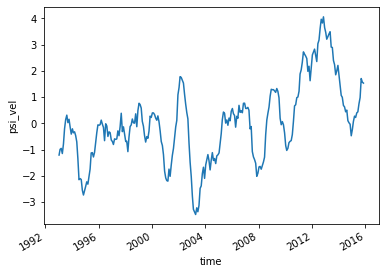

In [73]:
psi_anom_bot.plot();

### $\Omega$

In [74]:
omega_anom_bot = anomaly(bdy_omegas[6])
omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        1.96443654e+00,  2.15542159e+00,  2.26818886e+00,  2.30320339e+00,
        2.19685625e+00,  1.93630974e+00,  1.61171344e+00,  1.15225830e+00,
        1.29864347e+00,  1.35011307e+00,  1.23465589e+00,  1.28802594e+00,
        1.34756601e+00,  1.38277810e+00,  1.41032687e+00,  1.61636766e+00,
        1.72108848e+00,  1.59887290e+00,  1.59323827e+00,  1.54287672e+00,
        1.14017282e+00,  1.07262939e+00,  1.11030373e+00,  1.13271110e+00,
        1.05191838e+00,  9.58644040e-01,  8.74363532e-01,  6.20205486e-01,
        5.04678252e-01,  2.60962189e-01,  1.74599830e-01,  2.88978292e-01,
        3.50440025e-01,  1.52932264e-01,  5.91648432e-02, -1.16429478e-01,
       -1.82503982e-01, -2.95401877e-01, -3.28995835e-01, -4.85710950e-02,
        7.18854912e-02,  3.13071641e-01,  1.73234528e-01, -1.68456830e-01,
       -3.46601413e-01, -3.40817295e-01, -3.71859193e-01, -3.78200874e-01,
       -4.44121800e-01, -4.38833664e-01, -4.59382626e-01, -9.43279950e-01,
       -1.34123609e+00, -1.34269390e+00, -1.14778859e+00, -1.01748719e+00,
       -7.13962144e-01, -3.53688116e-01, -1.24675688e-01,  1.03878160e-01,
        3.33092438e-01,  6.27933198e-01,  8.07209329e-01,  1.13115233e+00,
        1.54472017e+00,  2.02378169e+00,  2.05192227e+00,  2.26917226e+00,
...
        4.48479665e-02, -2.32827622e-01, -5.13222874e-02,  4.38769658e-03,
       -1.29927821e-02, -5.20042069e-01, -7.05994136e-01, -1.05416492e+00,
       -1.41843596e+00, -1.70346433e+00, -1.95236012e+00, -2.37280123e+00,
       -2.43025668e+00, -2.83807819e+00, -3.06472725e+00, -3.36749904e+00,
       -3.71852036e+00, -3.80296347e+00, -4.01156056e+00, -4.12316120e+00,
       -4.18380051e+00, -4.23238486e+00, -4.26610290e+00, -4.37316088e+00,
       -4.71920994e+00, -4.64541754e+00, -4.57040636e+00, -4.31551477e+00,
       -3.90777536e+00, -3.61070813e+00, -3.25455815e+00, -2.77690755e+00,
       -2.27836814e+00, -1.80968558e+00, -1.46019039e+00, -7.91587403e-01,
       -1.55368490e-01,  4.92557836e-01,  6.00185233e-01,  6.07922872e-01,
        7.78132187e-01,  9.06050866e-01,  9.01985431e-01,  8.59732865e-01,
        8.02403573e-01,  7.64046128e-01,  9.58726684e-01,  9.41677449e-01,
        9.27984065e-01,  6.06433637e-01,  4.79956840e-01,  3.59195811e-01,
        2.18037972e-01,  2.88450672e-01,  3.73352141e-01,  3.56944086e-01,
        3.46164721e-01,  2.89518936e-01, -2.95854930e-02, -3.31341038e-01,
       -8.41499127e-01, -8.91463539e-01, -9.66603529e-01, -7.21766618e-01,
       -8.52972162e-01, -1.09533163e+00, -1.26872669e+00, -1.37297198e+00,
       -1.57051008e+00, -1.78778819e+00, -1.84343548e+00, -1.50526514e+00,
       -1.24641512e+00, -1.08732494e+00, -9.27109834e-01, -1.00894647e+00,
       -5.08415293e-01, -6.31289320e-01, -5.70982340e-01,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [75]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [76]:
omega_surf_slt_anom_bot = anomaly(bdy_omegas[4]).load()
omega_surf_th_anom_bot = anomaly(bdy_omegas[5]).load()
omega_mix_anom_bot = anomaly(bdy_omegas[0]).load()

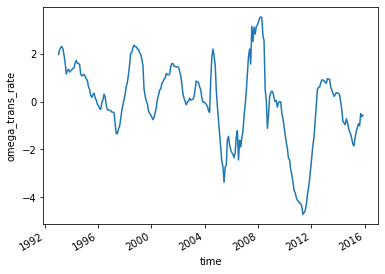

In [77]:
omega_anom_bot.plot();

### Residuals

In [78]:
#remember we are switching signs!
R1_anom_bot = - anom.R1.isel(sigma2_bin=-1) + anom.R1.isel(sigma2_bin=0)
R1_anom_bot.load()

<xarray.DataArray 'R1' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -4.00365129e-01, -3.62259451e-01, -4.89798605e-01, -5.81754219e-01,
       -7.24002340e-01, -6.93292063e-01, -5.82168563e-01, -4.23530736e-01,
       -2.60747063e-01, -2.67321613e-01, -2.53887758e-01, -3.18966703e-01,
       -3.47297682e-01, -4.25521604e-01, -4.77448309e-01, -3.39058725e-01,
       -3.04829062e-01, -3.37306383e-01, -3.30907792e-01, -4.36206827e-01,
       -4.42199078e-01, -3.99056086e-01, -3.09743032e-01, -2.99747371e-01,
       -1.44895524e-01, -3.64668286e-02,  1.00167748e-01,  9.51485027e-02,
        8.08177312e-02,  1.10301643e-01,  1.90683621e-01,  2.90320591e-01,
        2.74394261e-01,  3.07495327e-01,  2.71663947e-01,  4.12894555e-01,
        5.28786670e-01,  4.33154681e-01,  3.24251518e-01,  3.18218357e-01,
        5.19106819e-01,  3.51123966e-01,  3.77617360e-01,  2.61622319e-01,
        3.52566399e-01,  3.50781753e-01,  4.27521706e-01,  2.23437485e-01,
       -5.60718611e-03, -1.64573320e-02,  1.64781709e-02, -1.30587640e-01,
       -3.16875407e-01, -1.35279366e-01, -1.91786841e-01, -1.05488000e-01,
       -2.10263043e-01, -2.31346214e-01, -4.00394983e-01, -3.22595866e-01,
       -1.08514491e-01, -2.24983505e-01, -1.86729235e-01, -8.05680662e-03,
       -5.35540588e-02, -9.61630605e-02,  8.34137675e-02, -1.00107998e-01,
...
       -2.48165761e-01, -3.18819803e-01, -3.71899972e-01, -3.68811492e-01,
       -2.58564764e-01, -2.91340190e-01, -1.16378716e-01,  3.70428263e-01,
        6.09554182e-01,  9.48366868e-01,  8.16078755e-01,  8.28420747e-01,
        9.97350977e-01,  1.09629893e+00,  1.36716931e+00,  1.59142838e+00,
        1.75894400e+00,  1.84592370e+00,  1.80176748e+00,  1.53931747e+00,
        1.27772608e+00,  1.09642463e+00,  1.10311506e+00,  6.09919265e-01,
        4.08930358e-01,  1.83719859e-01, -1.95805027e-01, -3.67360936e-01,
       -1.78538580e-01, -2.68305373e-01, -4.77792924e-01, -7.40540341e-01,
       -7.19248970e-01, -8.50032492e-01, -7.31903534e-01, -4.53981782e-01,
       -2.96895020e-01, -2.36455147e-01, -1.28205046e-01, -2.46933565e-01,
       -7.10840118e-01, -7.99390491e-01, -7.81977945e-01, -6.35449131e-01,
       -5.76830016e-01, -3.93201034e-01, -4.08450801e-01, -3.91514045e-01,
       -4.68248380e-01, -4.22286446e-01, -5.43809952e-01, -5.42931967e-01,
       -5.17251914e-01, -5.33144703e-01, -5.52910482e-01, -4.31062236e-01,
       -5.07133142e-01, -5.40086459e-01, -5.71645858e-01, -4.65580026e-01,
       -4.40784777e-01, -2.37840185e-01,  7.74125396e-02, -6.62187367e-02,
       -1.91625655e-02,  8.05558230e-03,  8.59029888e-02,  2.58209010e-01,
        5.79328116e-01,  6.68737985e-01,  9.31367421e-01,  7.80865264e-01,
        8.57583465e-01,  8.40453643e-01,  4.05776278e-01,  6.56561616e-01,
        7.34889793e-01,  5.10296027e-01,  5.54458016e-01,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [79]:
#remember we are switching signs!
R2_anom_bot = - anom.R2.isel(sigma2_bin=-1) + anom.R2.isel(sigma2_bin=0)
R2_anom_bot.load()

<xarray.DataArray 'R2' (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -0.86850853, -0.86515151, -0.85984154, -0.85367252,
       -0.89118597, -0.86119752, -0.70807005, -0.66245853, -0.56011179,
       -0.54493753, -0.47650622, -0.40597004, -0.37906713, -0.38241266,
       -0.36512071, -0.3575834 , -0.28893002, -0.2599912 , -0.35642559,
       -0.56766674, -0.53721102, -0.50655334, -0.51418525, -0.54190312,
       -0.61159416, -0.53953474, -0.53224525, -0.65691542, -0.76422537,
       -0.71465867, -0.70460415, -0.7072448 , -0.80152965, -0.78343491,
       -0.82996043, -0.88832705, -0.82210754, -0.90626617, -0.88786783,
       -0.81439949, -0.7031397 , -0.80127931, -0.82265902, -0.7491751 ,
       -0.70123929, -0.7063216 , -0.64466569, -0.55945424, -0.58829973,
       -0.60384547, -0.69617127, -0.71709356, -0.81709717, -0.78357975,
       -0.82862167, -0.87087601, -0.93394126, -1.00592187, -1.06087524,
       -1.10013226, -1.09137366, -1.07621689, -1.13595607, -1.12899841,
       -1.07968313, -0.97643401, -0.78873173, -0.67560502, -0.46345407,
       -0.25095395, -0.16512937, -0.12959975,  0.01061242,  0.0627969 ,
        0.16783154,  0.13409417,  0.18583832,  0.09988602,  0.0491545 ,
       -0.00297684, -0.12692837, -0.26925961, -0.36692162, -0.45081971,
       -0.54416097, -0.59126908, -0.59816799, -0.62045379, -0.68177728,
...
        1.45241197,  1.34053256,  1.28253215,  1.1406151 ,  1.09230578,
        0.90567446,  0.59146449,  0.55748242,  0.52819186,  0.37473131,
        0.2686582 ,  0.10837401, -0.02406374,  0.05411504,  0.04099623,
        0.06755573, -0.093804  ,  0.00518654,  0.01272537,  0.08403558,
        0.11781553,  0.20697489,  0.28202867,  0.37936318,  0.39818461,
        0.42307194,  0.44574513,  0.45573638,  0.54885686,  0.49458259,
        0.41205469,  0.29842723,  0.25589161,  0.18484942,  0.15786803,
        0.11507643,  0.0991483 ,  0.0887112 ,  0.09876513,  0.11409715,
        0.10911135,  0.18989863,  0.32120324,  0.4025048 ,  0.47785216,
        0.55655328,  0.5741284 ,  0.66607799,  0.80015081,  0.82150974,
        0.78258564,  0.78253967,  0.76557102,  0.71076655,  0.63405869,
        0.49154421,  0.43876024,  0.41096077,  0.37915076,  0.31130927,
        0.23870524,  0.20551979,  0.228532  ,  0.18882265,  0.27814696,
        0.25742874,  0.24109101,  0.44463668,  0.55200206,  0.6205582 ,
        0.70919422,  0.7600571 ,  0.73485075,  0.75496795,  0.72508811,
        0.71913696,  0.66538382,  0.72270414,  0.81895682,  0.73831239,
        0.68153693,  0.62938215,  0.59345916,  0.64896143,  0.72020552,
        0.71442062,  0.71089994,  0.73437103,  0.69808726,  0.69436883,
        0.69802624,  0.70153402,  0.74188423,  0.76709278,  0.70662489,
        0.66409099,  0.58182598,  0.54848126])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

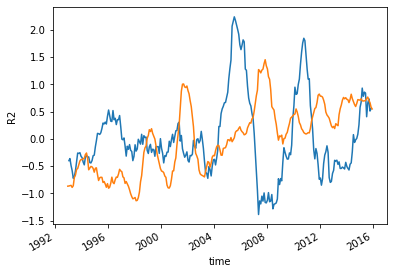

In [80]:
R1_anom_bot.plot(label='R1')
R2_anom_bot.plot(label='R2');

In [81]:
dVdt_anom_bot.time[-1]

<xarray.DataArray 'time' ()>
array('2015-12-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time      datetime64[ns] 2015-12-14
    time_snp  datetime64[ns] NaT
    month     int64 12

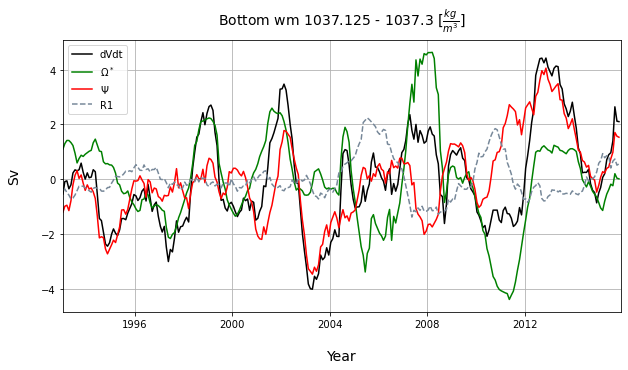

In [82]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[12], dVdt_anom_bot.time[-1]) #1993-2015

plt.legend()
plt.grid();

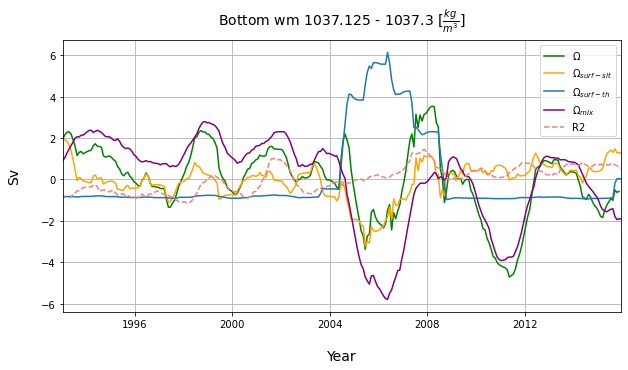

In [83]:
fig = plt.subplots(figsize=(10,5))
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_anom_bot.time, omega_surf_slt_anom_bot, 
         label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_anom_bot.time, omega_surf_th_anom_bot, 
         label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_anom_bot.time, omega_mix_anom_bot, 
         label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[12], dVdt_anom_bot.time[-1]) #1993-2015

plt.legend()
plt.grid();

### __Bottom anomaly budget__

In [84]:
(- dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot).mean('time')

<xarray.DataArray ()>
array(0.00166499)

In [85]:
anom_budget = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot
anom_budget

<xarray.DataArray (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        3.28604323e-02,  3.26518928e-02,  3.29204936e-02,  3.29977086e-02,
        3.29696111e-02,  1.02293991e-01,  1.68532395e-01,  1.74455347e-01,
        1.75199564e-01,  1.75852192e-01,  1.76918705e-01,  1.78015070e-01,
        1.78554133e-01,  1.79070397e-01,  1.78868476e-01,  1.79167894e-01,
        1.78842525e-01,  1.09461520e-01, -1.58810740e-02, -2.15018338e-02,
       -2.14186162e-02, -2.09860921e-02, -2.04920902e-02, -2.02158391e-02,
       -2.00052865e-02, -1.98420908e-02, -1.93144715e-02, -1.97321786e-02,
       -1.98012879e-02, -1.98035546e-02, -1.99618615e-02, -2.00188698e-02,
       -2.04716363e-02, -2.10855001e-02, -2.15284753e-02, -2.16689895e-02,
       -2.12597415e-02, -2.07311847e-02, -2.04889618e-02, -2.04556466e-02,
       -2.01584471e-02, -2.04655625e-02, -2.05777988e-02, -2.10741385e-02,
       -2.13369497e-02, -2.17808251e-02, -2.23113974e-02, -2.28096633e-02,
       -2.34944556e-02, -2.40932354e-02, -2.44988713e-02, -2.44919005e-02,
       -2.45292221e-02, -2.43019455e-02, -2.37946586e-02, -2.32102800e-02,
       -2.23023920e-02, -2.14274389e-02, -2.05740736e-02, -2.04273200e-02,
       -2.04515800e-02, -2.05036512e-02, -2.06761928e-02, -2.06531073e-02,
       -2.74117297e-02,  8.72922534e-02,  9.10368960e-02,  7.68033043e-02,
...
       -1.38387471e-02, -1.33214874e-02, -1.29655692e-02, -1.28089628e-02,
       -1.35397342e-02, -1.47137814e-02, -1.58469304e-02, -1.61015227e-02,
       -1.57070161e-02, -1.49700579e-02, -1.38664634e-02, -1.28353500e-02,
       -1.19570333e-02, -1.08051027e-02, -9.46283919e-03, -7.62796428e-03,
       -5.32443669e-03, -2.69565092e-03, -1.44535591e-04,  1.65797614e-03,
        3.60561528e-03,  4.99559203e-03,  5.62333540e-03,  6.03735463e-03,
        6.34436355e-03,  5.70634536e-03,  4.58650281e-03,  2.91853710e-03,
        1.08724139e-03, -9.18672041e-04, -3.20933361e-03, -5.03572483e-03,
       -7.50270442e-03, -9.65661387e-03, -1.11575518e-02, -1.21869496e-02,
       -1.31301327e-02, -1.29735579e-02, -1.28689603e-02, -1.25942687e-02,
       -1.19759121e-02, -1.19233369e-02, -1.15296058e-02, -1.16574069e-02,
       -1.13288590e-02, -1.09013605e-02,  7.82720087e-02,  7.83055229e-02,
        7.84943240e-02,  7.80829983e-02,  7.80042295e-02,  7.75287915e-02,
        7.64574235e-02,  7.60031968e-02,  7.55754364e-02,  7.50680528e-02,
        7.47024335e-02,  7.43686517e-02, -1.48888762e-02, -1.49587247e-02,
       -1.49626595e-02, -1.45770199e-02, -1.42596388e-02, -1.30536234e-02,
       -1.14527181e-02, -1.04476023e-02, -9.15554913e-03, -7.89319429e-03,
       -6.72932705e-03, -5.62337451e-03, -4.54246903e-03, -3.58948928e-03,
       -2.59786832e-03, -1.22558735e-03,  1.39426700e-04,  1.55947716e-04,
       -4.16138119e-03, -5.44345267e-03, -5.50279854e-03,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [86]:
anom_bdgt_nores = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot
anom_bdgt_nores

<xarray.DataArray (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        1.29837707e+00,  1.25475288e+00,  1.37639162e+00,  1.50593790e+00,
        1.61816947e+00,  1.50365610e+00,  1.41315949e+00,  1.15809787e+00,
        9.80884157e-01,  9.19680023e-01,  8.36776501e-01,  8.76048906e-01,
        9.08264476e-01,  9.69712707e-01,  1.01390018e+00,  8.07156644e-01,
        7.43662790e-01,  8.03193492e-01,  8.82693462e-01,  9.51916010e-01,
        9.27333804e-01,  8.92255246e-01,  8.31154058e-01,  8.91125693e-01,
        6.64424977e-01,  5.48869991e-01,  5.37433204e-01,  6.49344688e-01,
        6.14039649e-01,  5.74498956e-01,  4.96599319e-01,  4.91190186e-01,
        4.88569012e-01,  5.01379603e-01,  5.95134628e-01,  3.87543991e-01,
        3.56219758e-01,  4.33981961e-01,  4.69659010e-01,  3.64465697e-01,
        2.62014043e-01,  4.51069491e-01,  3.50979937e-01,  4.18542828e-01,
        3.32418251e-01,  2.72103112e-01,  1.09621135e-01,  3.42052585e-01,
        5.85958205e-01,  6.88535365e-01,  6.76116514e-01,  9.23192911e-01,
        1.07592594e+00,  9.39599092e-01,  1.03886819e+00,  1.01621898e+00,
        1.19388252e+00,  1.27079402e+00,  1.47995317e+00,  1.39354221e+00,
        1.16427980e+00,  1.34043593e+00,  1.29505145e+00,  1.06708683e+00,
        1.00257634e+00,  9.72187046e-01,  6.83228148e-01,  6.40365373e-01,
...
        2.21601642e-01,  2.21462735e-01,  2.41118873e-01,  1.49027635e-01,
       -3.70036406e-02, -1.02736773e-01, -2.97652823e-01, -8.09601729e-01,
       -1.07100633e+00, -1.41907331e+00, -1.37880208e+00, -1.33583869e+00,
       -1.42136270e+00, -1.40553127e+00, -1.63252376e+00, -1.78390576e+00,
       -1.92213647e+00, -1.96369579e+00, -1.90106031e+00, -1.62637069e+00,
       -1.37288560e+00, -1.20552619e+00, -1.20660307e+00, -7.93780536e-01,
       -7.23789236e-01, -5.80518315e-01, -2.77460632e-01, -1.86273811e-01,
       -3.94502583e-01, -3.98691286e-01, -3.25567218e-01, -8.60051228e-02,
       -7.08393770e-02,  5.78362121e-02, -4.48250333e-02, -2.68971719e-01,
       -3.50293805e-01, -2.68062622e-01, -3.23424158e-01, -1.76621475e-01,
        3.19713450e-01,  4.76157880e-01,  5.31743097e-01,  4.18271935e-01,
        3.36969158e-01,  1.93477026e-01,  2.08575852e-01,  2.12390831e-01,
        3.05651697e-01,  5.57327646e-02,  6.98121253e-02, -9.74404944e-05,
       -1.15484885e-01, -1.50909200e-01, -1.06364831e-01, -2.48837661e-01,
       -1.43252530e-01, -1.04681851e-01, -1.08626836e-01, -2.72082839e-01,
       -3.93134701e-01, -5.15049226e-01, -7.73209109e-01, -5.76217034e-01,
       -5.85749315e-01, -6.67464614e-01, -8.15264058e-01, -9.80522820e-01,
       -1.29695738e+00, -1.40873239e+00, -1.63399715e+00, -1.47882358e+00,
       -1.55820757e+00, -1.54321325e+00, -1.14752109e+00, -1.42349845e+00,
       -1.44567606e+00, -1.17983047e+00, -1.14178679e+00,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

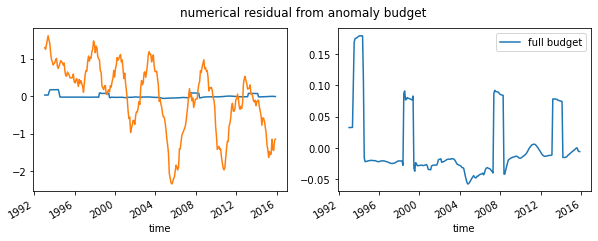

In [87]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
anom_budget.plot(ax=ax0, label='full budget')
anom_bdgt_nores.plot(ax=ax0, label='no residuals')

anom_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from anomaly budget');

### Boundary $\Omega$s

## Indices

In [88]:
indices

<xarray.Dataset>
Dimensions:          (time: 288)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    ecco             (time) float32 -1.17 -0.4881 0.557 ... 0.9576 0.7435 -2.925
    enso             (time) float32 1.884 1.786 1.615 ... 2.599 2.746 2.795
    fw_flx           (time) float32 -1.3 -0.8691 -2.231 ... 0.3026 0.3995 1.555
    heat_flx         (time) float32 0.001594 -0.8675 -1.919 ... -0.1446 5.151
    sam              (time) float64 -0.1225 -0.8858 -0.616 ... 0.8338 0.3187
    windstress_curl  (time) float64 -0.2194 1.103 -0.4354 ... -0.5297 0.2877

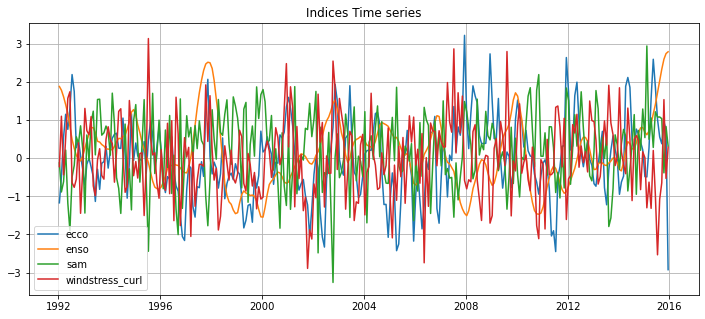

In [90]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    if i=='fw_flx':
        continue
    if i=='heat_flx':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

## Heat map of Corralation matrices

In [91]:
import seaborn as sn

In [92]:
indices_df = indices.to_dataframe()
indices_df.head()

,ecco,enso,fw_flx,heat_flx,sam,windstress_curl
time,,,,,,
1992-01-15,-1.170194,1.883747,-1.300427,0.001594,-0.122525,-0.219413
1992-02-13,-0.488146,1.786449,-0.869125,-0.867469,-0.885817,1.102549
1992-03-15,0.556974,1.614739,-2.230632,-1.918516,-0.616002,-0.435378
1992-04-14,1.153485,1.408937,-0.181473,0.300216,0.213964,0.524290
1992-05-15,0.758463,1.166296,-0.546701,0.713055,-1.179878,1.575049


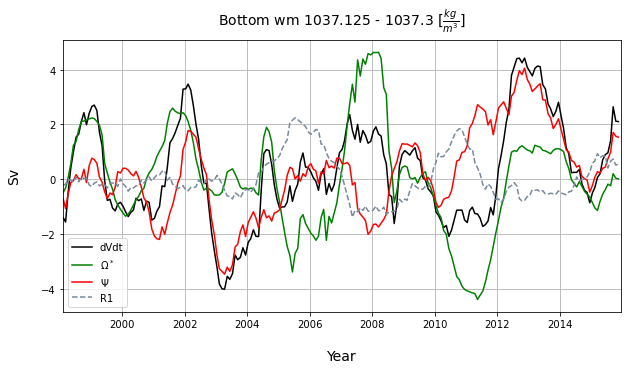

In [93]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

In [94]:
omega_star = omega_anom_bot + R2_anom_bot

In [101]:
ds = xr.merge([dVdt_anom_bot.rename('dvdt'), psi_anom_bot.rename('psi'), omega_star.rename('omega*')]).drop(['month', 'time_snp'])
ds

<xarray.Dataset>
Dimensions:  (time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    dvdt     (time) float64 nan nan nan nan nan ... 1.395 2.643 2.116 2.101 nan
    psi      (time) float64 nan nan nan nan nan ... 0.9805 1.705 1.568 1.531 nan
    omega*   (time) float64 nan nan nan nan nan ... 0.1982 0.0328 0.01084 nan

In [102]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [103]:
indices.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [104]:
budget_df = ds.to_dataframe()

In [105]:
budget_df.tail()

,dvdt,psi,omega*
time,,,
2015-08-15,1.395031,0.980479,-0.241854
2015-09-14,2.642567,1.705306,0.198210
2015-10-15,2.116256,1.567715,0.032802
2015-11-14,2.101443,1.530638,0.010844
2015-12-14,NaN,NaN,NaN


### Correlation matrix of all terms (budget & indices)

In [106]:
budget_ind = pd.concat([budget_df, indices_df], axis=1)
budget_ind.tail()

,dvdt,psi,omega*,ecco,enso,fw_flx,heat_flx,sam,windstress_curl
time,,,,,,,,,
2015-08-15,1.395031,0.980479,-0.241854,0.559372,2.045500,0.225318,-0.579957,1.083196,-1.076998
2015-09-14,2.642567,1.705306,0.198210,0.380170,2.336527,-0.677235,-0.413434,1.039752,-0.643988
2015-10-15,2.116256,1.567715,0.032802,0.957576,2.599419,0.302553,-0.738937,-0.384399,1.538923
2015-11-14,2.101443,1.530638,0.010844,0.743491,2.746488,0.399466,-0.144605,0.833789,-0.529735
2015-12-14,NaN,NaN,NaN,-2.925005,2.794896,1.555206,5.150780,0.318706,0.287670


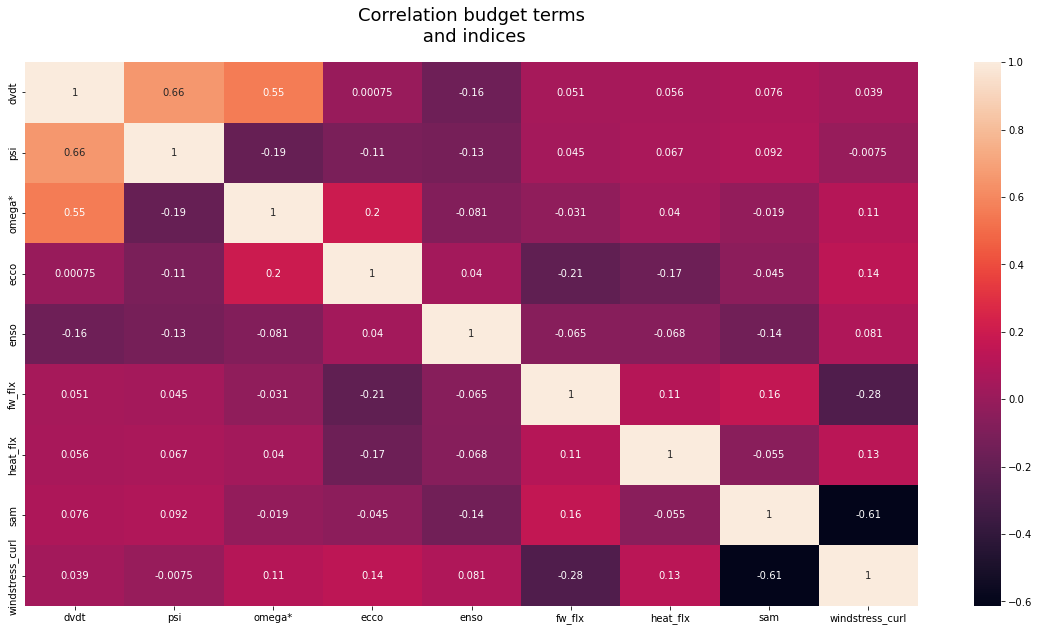

In [107]:
plt.figure(figsize=(20,10))
sn.heatmap(budget_ind.corr(), annot=True)
plt.title('Correlation budget terms\n and indices', fontsize=18, pad=20.5);